# Colab directory setting
if use colab, need to update whole SHQCS folder to the google drive first

In [1]:
####Run this cell if using Colab####
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Specify the new path to which you want to change the directory
new_directory = "drive/MyDrive/SHQCS/Python_side"

# Change the current working directory
os.chdir(new_directory)

# Verify the change
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  /content/drive/MyDrive/SHQCS/Python_side


# All used libraries needed for this project

In [3]:
pip install pyod keras_tuner sqlalchemy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-2.0.0-py3-none-any.whl size=196324 sha256=035635cd469c49be0d7407fa95d52ba8a1f90a65bbbb836adc0dc5c8d1b3ab26
  Stored in directory: /root/.cache/pip/wheels/15/0e/91/96b270e6741d4eece88727489411330226ff47ac1cb9ea0097
Successfully built pyod


In [4]:
# custimized libraries
from data_preprocessing import moving_average
from visualization import log_vis, normal_vis
from data_loading import load_data
import datetime as dt
from naive_anomaly_detection import anomaly_detection, classify_anomalies

# utilities
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

# date&time
import pytz
import matplotlib.dates as md

# sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, validation_curve, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# outlier detection
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# tensorflow
import tensorflow as tf
from keras_tuner import HyperModel
from keras_tuner import HyperParameters
from keras_tuner.tuners import BayesianOptimization, Hyperband
from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import Huber

# autoreload all extensions
%reload_ext autoreload
%autoreload 2

# Introduction and Preparation
## (Only for presentation, Can just skip this part when running notebook.)

This introduction section records the overall workthrough against analyzing the sensors's data, some discoveries & insights about the data pattern. A prototype also have been designed to identify anomalies would also be proposed in this section

The load_data function below implement the function that can retrieve the data from database with given table, channel, date range.  
The normal_vis function will then generate a standard data value against timestamp graph according to the retrieved data

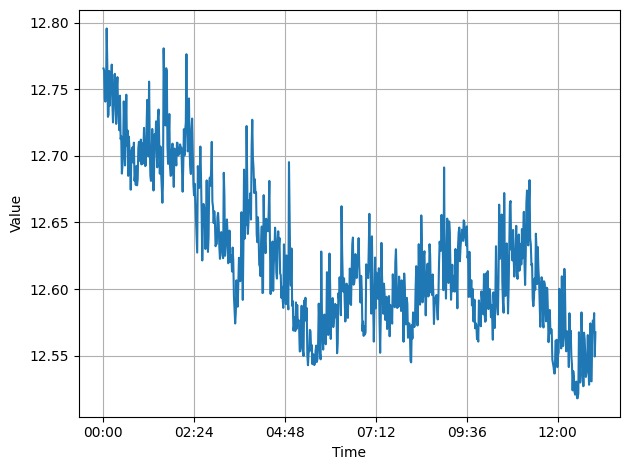

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=0)
date2 = dt.datetime(year=2024, month=1, day=18,hour=13)
temperatures, timestamps = load_data("temperature", "MXC", date1, date2)
normal_vis(timestamps,temperatures)

If the time stamp across several databases, the load_data function will load all corresponed data from all existing databases.  
It is noticed that the data now came from three time period separately from three databases: 2023/08/31 to 2023/09/23, 2023/09/26 to 2023/09/26 to 2023/10/04, and 2024/01/11 to 2014/01/19.  
Overall period and the plot of all data is shown as below:

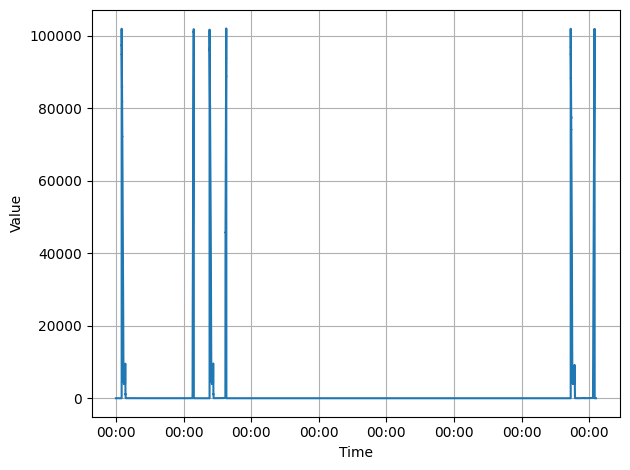

In [ ]:
date1 = dt.datetime(year=2023,month=1,day=1)
date2 = dt.datetime(year=2024,month=2, day=1)
temperatures, timestamps = load_data("temperature", "MXC", date1, date2)
normal_vis(timestamps,temperatures)

## 2024/01/18 to 2024/01/19

Focusing with the period from 2024/01/18 to 2024/01/19, which the second spike at around 2024/01/19 1 o'clock AM is caused by a known cooling pump faliure.  
The log_vis function visulize all data from given channels in given date period, plotting in log scale (so observing fluctuations at low value ranges clearly) and shifted (by dividing the first element to every element in the series) so all signals aligned with each other.

The cooling water temperature plot is visualized below and expain the event happened

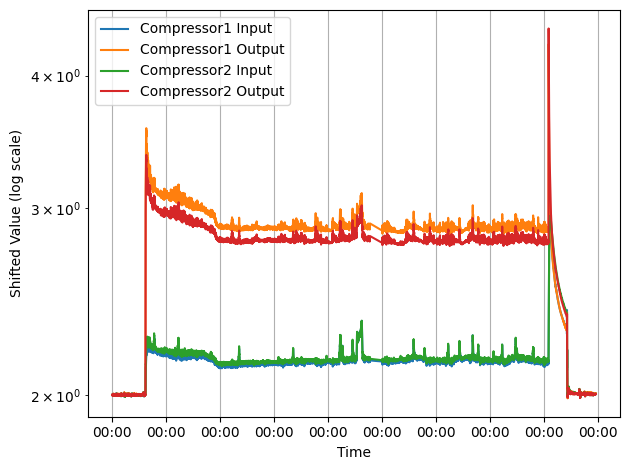

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=11,hour=0)
date2 = dt.datetime(year=2024, month=1, day=19,hour=23)

labels = ["Compressor1","Compressor2"]
valuelist = []
for label in labels:
    for io in ["Input","Output"]:
        values,timestamps = load_data("cooling_water",label,date1, date2,io)
        valuelist.append(values)

legend = ["Compressor1 Input","Compressor1 Output","Compressor2 Input","Compressor2 Output"]
log_vis(timestamps,legend,valuelist)

Checking with the temperature data, we observed that the temperature of all channels increased just at the point when pump faliure occured.  
MXC drops to 0 at the end (but it's because the limit of MXC is 100K, so value higher than that drops to 0).  
(If MXC rise to 200 mk the qc down)  
However, there is no trend for other channels that return to the normal value, showing the cooling pump faliure is never fixed.

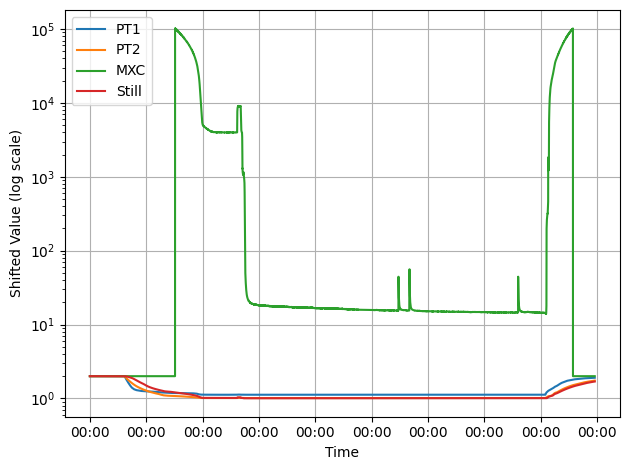

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=11,hour=0)
date2 = dt.datetime(year=2024, month=1, day=19,hour=23)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)


Focusing to the start of the spike, we observe that the PT2 react the fastest to the anormality.

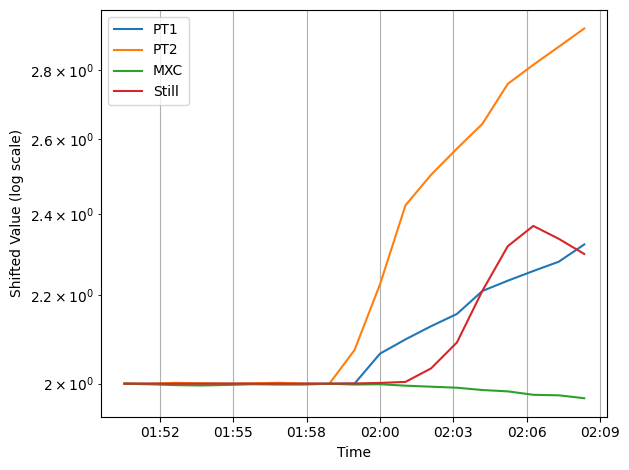

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=19,hour=1,minute=50)
date2 = dt.datetime(year=2024, month=1, day=19,hour=2,minute=10)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Check how pressure data varies during this period

The pressure data of different channels seem like don't follow a similar pattern.  
The VacuumCan's value is continuelly rising, however, all other channels keep constant to a fixed value at the end (what's the reason causing this?)

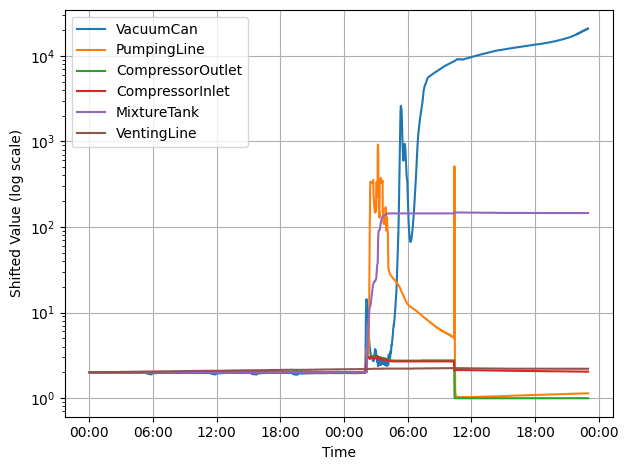

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=0)
date2 = dt.datetime(year=2024, month=1, day=19,hour=23)
channels = ["VacuumCan","PumpingLine","CompressorOutlet","CompressorInlet","MixtureTank","VentingLine"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("pressure", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Inspect what's the normal value for these pressure channels. (2024/01/18 1 o'clock to 2024/01/19 1 o'clock, which appears to be almost flat lines for all channels in the above graph)

We can see below the VacuumCan channel is experiencing a regular fluctuation with the interval of approximately 5 hours.  
The VentingLine channel is experiencing an continuous step-like rising (possibly due to the low detecting frequency of the sensor) even the temperature in this time period is at the normal value.  
all other four channels are very noisy but remain relatively constant.

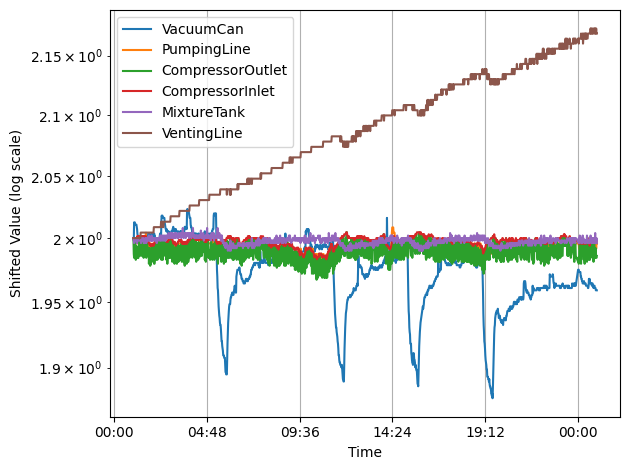

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=1)
date2 = dt.datetime(year=2024, month=1, day=19,hour=1)
channels = ["VacuumCan","PumpingLine","CompressorOutlet","CompressorInlet","MixtureTank","VentingLine"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("pressure", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Focusing the pressure data at the begining of the spike of the temperature data for reference.

From the visulization below, we can see almost all of the pressure channel react at the same time but the VaccumCan holds strongest reaction in magnitude.  
The start time is also similar with the temperature data which is around 1:58.

A Problem occured here is what's the unit for the pressure? (Although in log scale below)

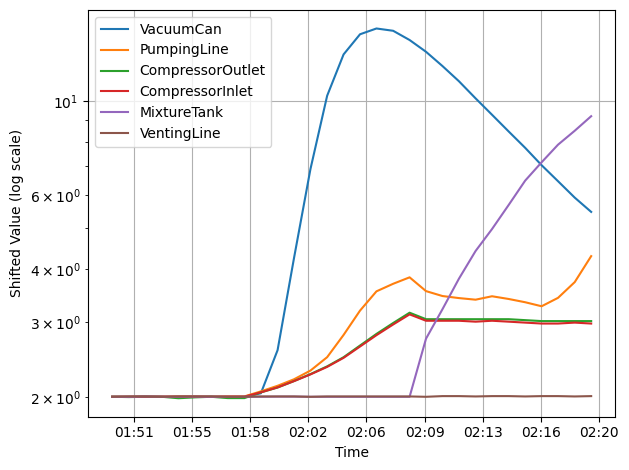

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=19,hour=1,minute=50)
date2 = dt.datetime(year=2024, month=1, day=19,hour=2,minute=20)
channels = ["VacuumCan","PumpingLine","CompressorOutlet","CompressorInlet","MixtureTank","VentingLine"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("pressure", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Changing focus to the first spike in temperature data happened at around 2024/01/18 14 0'clock, which is due to the operation of a RF switch inside the fridge

Only the MXC temperature increased to four times of the normal value, all other channels are remained the same.

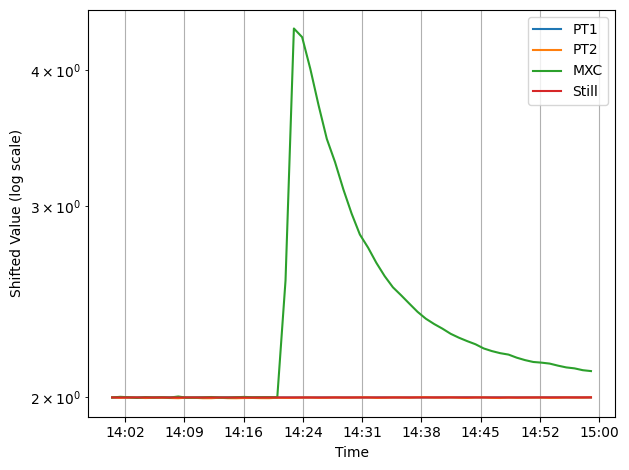

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=14)
date2 = dt.datetime(year=2024, month=1, day=18,hour=15)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Check what happened to pressure for this first spike in MXC temperature channel.  
We can see from the plot that there is no obvious change in pressure data that potentially caused by the MXC temperature spike.

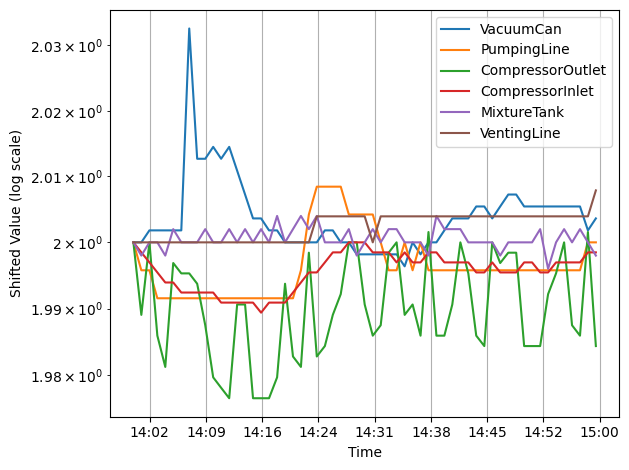

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=14)
date2 = dt.datetime(year=2024, month=1, day=18,hour=15)
channels = ["VacuumCan","PumpingLine","CompressorOutlet","CompressorInlet","MixtureTank","VentingLine"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("pressure", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

### Normal data extraction
based on MXC(useful for the machine learnings later)

Normal data between 2024/01/11 to 2024/01/19

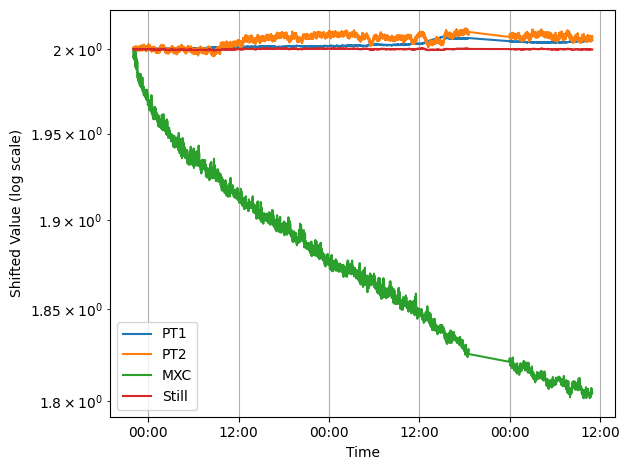

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=13,hour=22)
date2 = dt.datetime(year=2024, month=1, day=16, hour= 11)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)


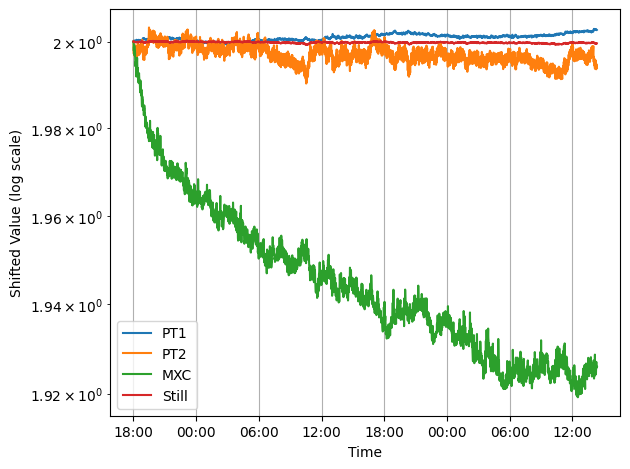

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=16,hour=18)
date2 = dt.datetime(year=2024, month=1, day=18, hour= 14, minute= 20)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

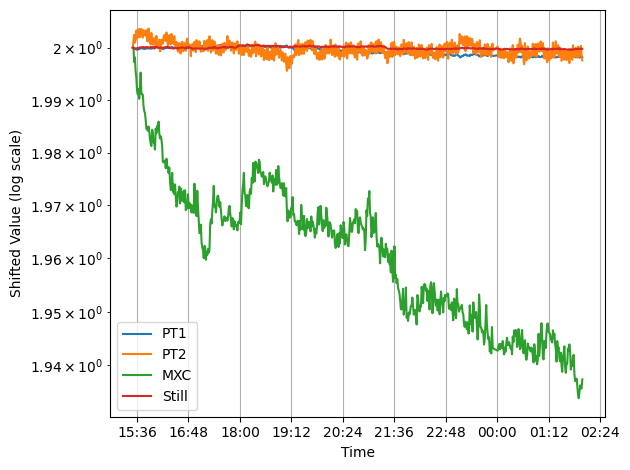

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18, hour= 15, minute= 30)
date2 = dt.datetime(year=2024, month=1, day=19, hour= 1, minute=59)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

## 2023/09/26 to 2023/10/04

Explore the data in time period 2023/09/26 to 2023/10/04 which comes from another database.  
We can see from the cooling water temperature first, seems like there was also a pump faliure.

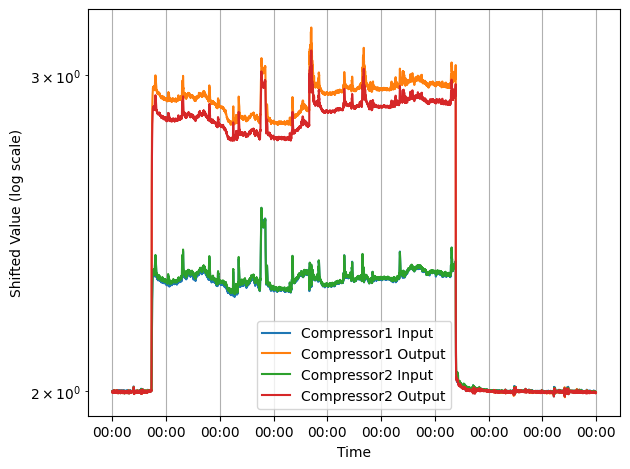

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=26)
date2 = dt.datetime(year=2023, month=10, day=5)

labels = ["Compressor1","Compressor2"]
valuelist = []
for label in labels:
    for io in ["Input","Output"]:
        values,timestamps = load_data("cooling_water",label,date1, date2,io)
        valuelist.append(values)

legend = ["Compressor1 Input","Compressor1 Output","Compressor2 Input","Compressor2 Output"]
log_vis(timestamps,legend,valuelist)

Checking how's the temperature data during this period.  
We can see from the graph, only MXC temperature in rising higher, experiencing a dropdown in the middle, but rise again before turn to normal value.(This is because of the MXC scale limit of 100k).   
In contrast the temperature of all other channels decreased in react to this anomaly. (Which is correct because the fridge is cooling down)

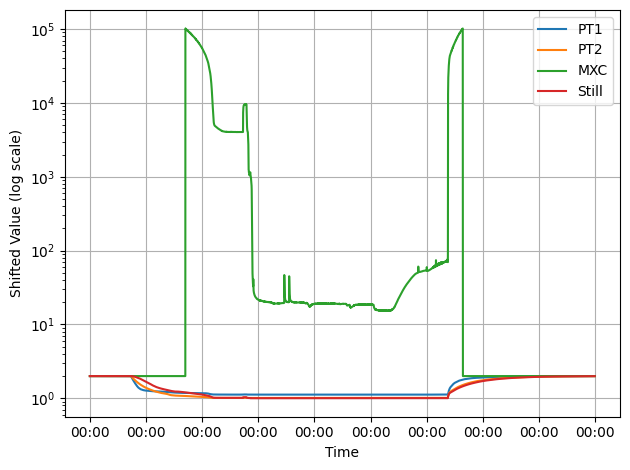

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=26)
date2 = dt.datetime(year=2023, month=10, day=5)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Focusing to the start of this anomaly in temperature

We can see PT2 is again react fastest in time, but PT1 varies faster into higher magnitude

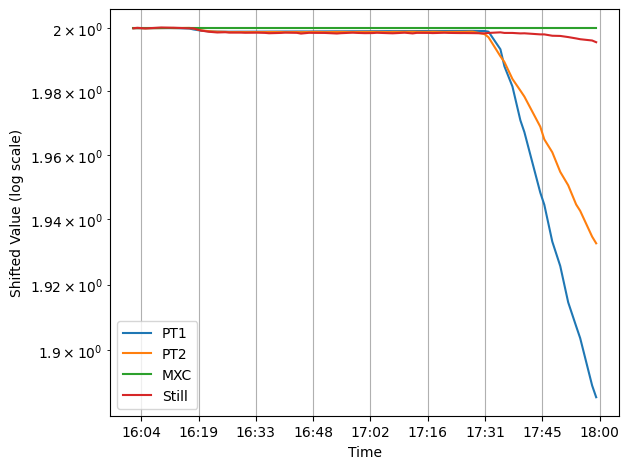

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=26,hour=16)
date2 = dt.datetime(year=2023, month=9, day=26,hour=18)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Then check how's the pressure data varying during this period.
As we could see from this graph, the pressure data again don't seems like follow a certain pattern.  
Some channels increase in pressure during the pump faliure period, but some remains approximately the same and some even decreased.  
The CompressorOutlet is "disappeared" at some places in the plot, this is because it dropped down to a negative value, so it cannot be shown in the log plot here

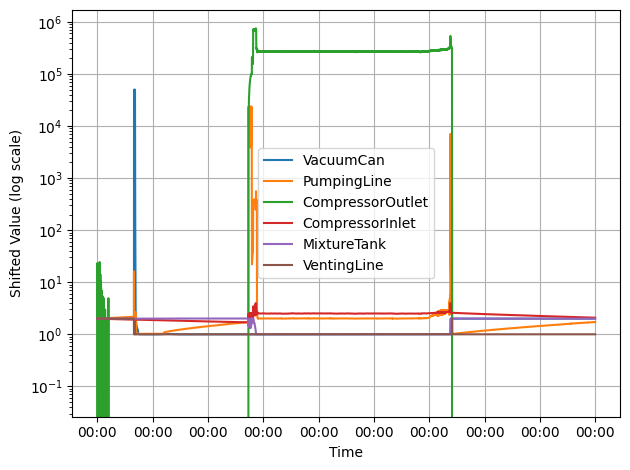

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=26)
date2 = dt.datetime(year=2023, month=10, day=5)
channels = ["VacuumCan","PumpingLine","CompressorOutlet","CompressorInlet","MixtureTank","VentingLine"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("pressure", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Plot the CompressorOutlet channel in a normal scale from 9/26 to 9/27.  
we can see it's dropping down from 0 to -3. (what does negative value mean here?)

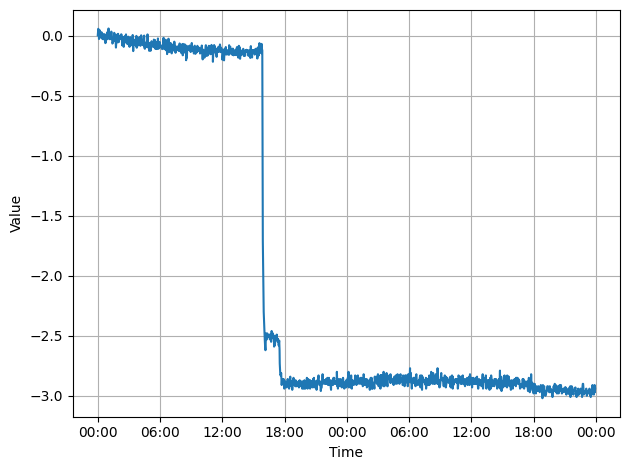

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=26)
date2 = dt.datetime(year=2023, month=9, day=28)
values, timestamps = load_data("pressure", "CompressorOutlet", date1, date2)
normal_vis(timestamps,values)

Continue explore the pressure data here during no pump faliure.
we can see all pressure data is flat, this is different from what we saw during 2024/1/18 to 2024/1/19, where some channels experienced step-like rising and some experienced periodic fluctuation.

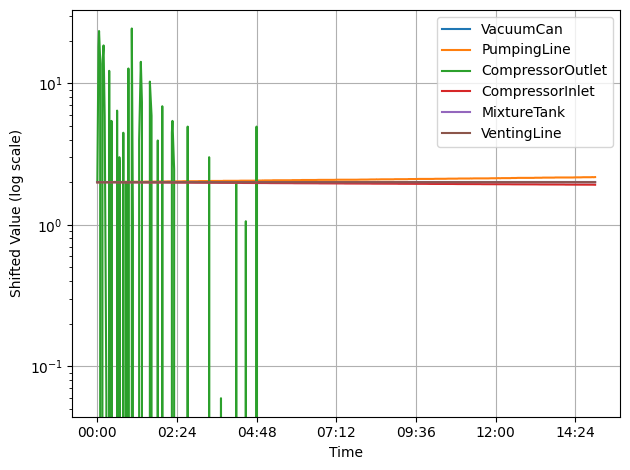

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=26,hour=0)
date2 = dt.datetime(year=2023, month=9, day=26,hour=15)
channels = ["VacuumCan","PumpingLine","CompressorOutlet","CompressorInlet","MixtureTank","VentingLine"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("pressure", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

### Normal data extraction

Normal data between 2023/09/26 to 2023/10/04

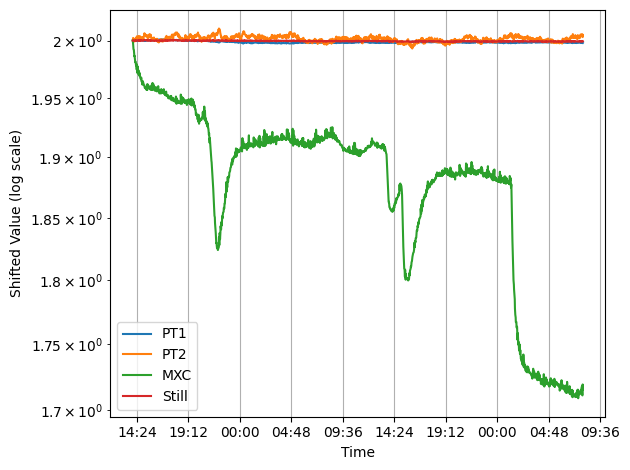

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=29,hour=14)
date2 = dt.datetime(year=2023, month=10,day=1,hour=8)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

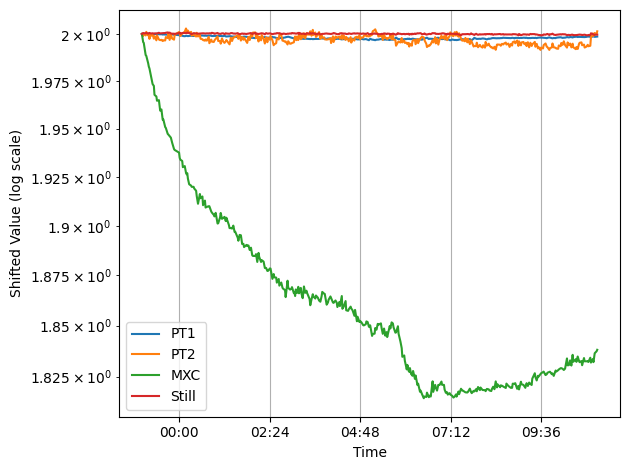

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=28,hour=23)
date2 = dt.datetime(year=2023, month=9, day=29,hour=11, minute=5)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

## 2023/08/31 to 2023/09/23

Check the cooling water temperature for reference first again.

The cooling water temperature maintained high in this month.

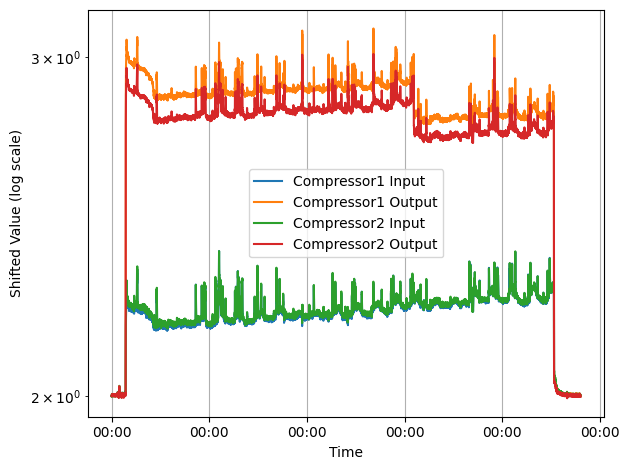

In [ ]:
date1 = dt.datetime(year=2023, month=8, day=31)
date2 = dt.datetime(year=2023, month=9, day=24)

labels = ["Compressor1","Compressor2"]
valuelist = []
for label in labels:
    for io in ["Input","Output"]:
        values,timestamps = load_data("cooling_water",label,date1, date2,io)
        valuelist.append(values)

legend = ["Compressor1 Input","Compressor1 Output","Compressor2 Input","Compressor2 Output"]
log_vis(timestamps,legend,valuelist)

Focusing on the temperature data, we can see a similar plot to the previous one.

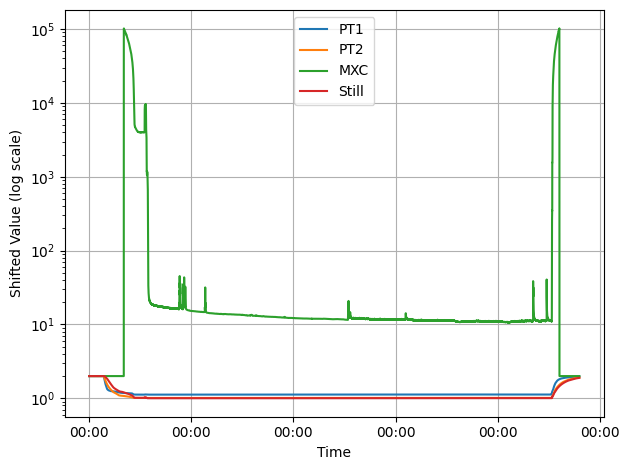

In [ ]:
date1 = dt.datetime(year=2023, month=8, day=31)
date2 = dt.datetime(year=2023, month=9, day=24)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

Focusing to the start of the spike, we observe again that PT2 react fastest in time while PT1 react fastest in magnitude.

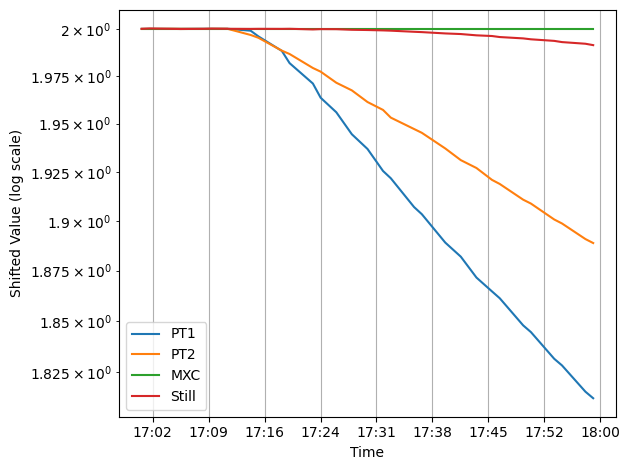

In [ ]:
date1 = dt.datetime(year=2023, month=8, day=31,hour=17)
date2 = dt.datetime(year=2023, month=8, day=31,hour=18)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

The pressure data also shows similar pattern as the previous one.  
What's the abnormal threshold for pressure if we want to label it?

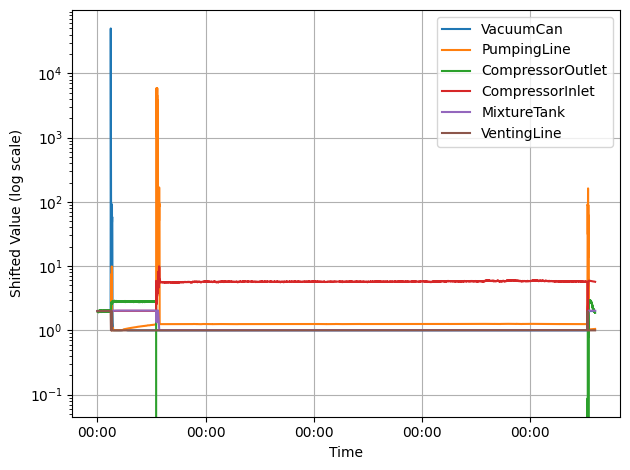

In [ ]:
date1 = dt.datetime(year=2023, month=8, day=31)
date2 = dt.datetime(year=2023, month=9, day=23)
channels = ["VacuumCan","PumpingLine","CompressorOutlet","CompressorInlet","MixtureTank","VentingLine"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("pressure", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

### Normal data extraction

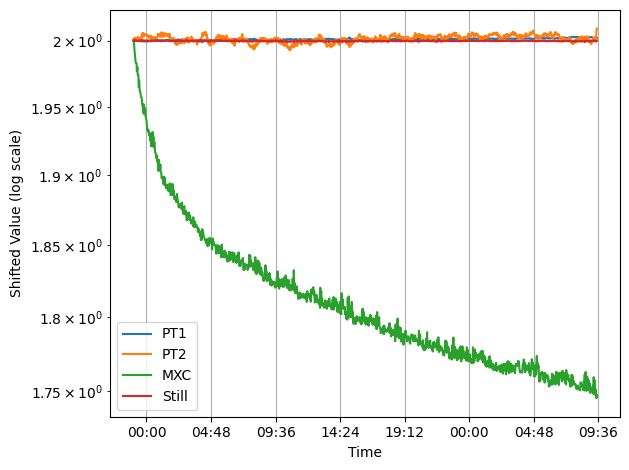

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=2,hour=23)
date2 = dt.datetime(year=2023, month=9, day=4,hour=9,minute=30)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

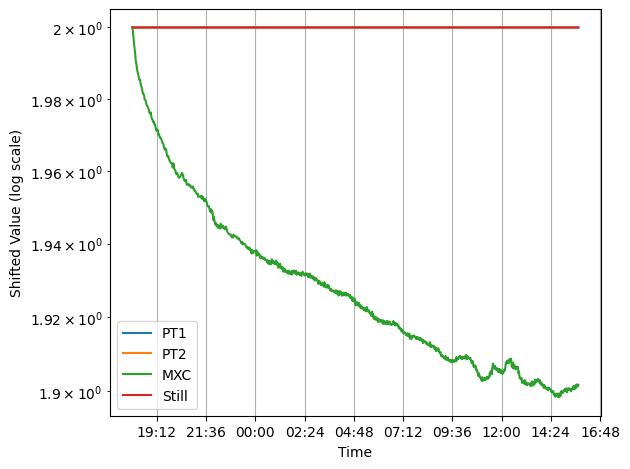

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=4,hour=18)
date2 = dt.datetime(year=2023, month=9, day=5,hour=15,minute=45)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

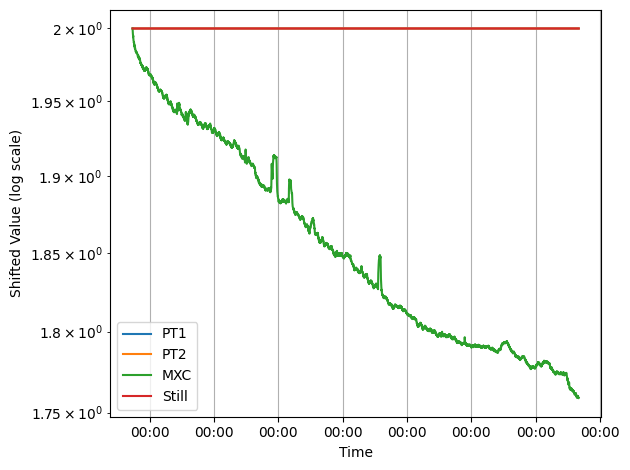

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=5,hour=17,minute=40)
date2 = dt.datetime(year=2023, month=9, day=12,hour=16)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

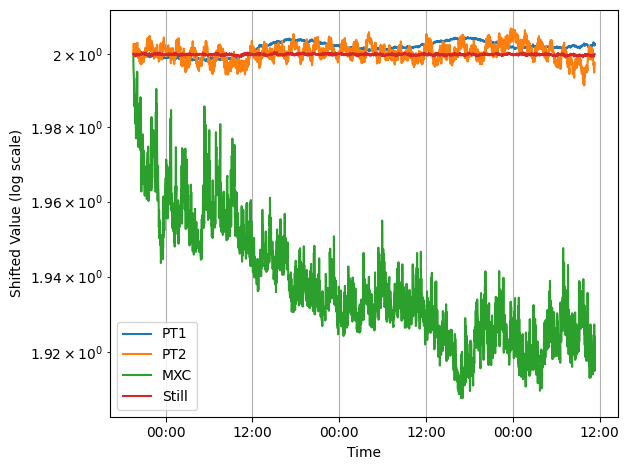

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=12,hour=19,minute=30)
date2 = dt.datetime(year=2023, month=9, day=15,hour=11,minute=20)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

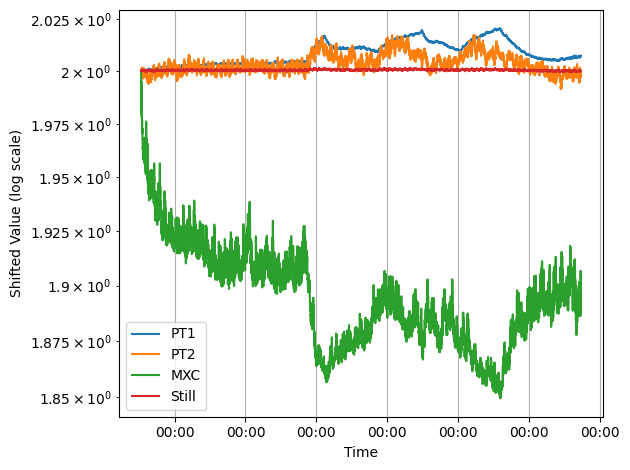

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=15,hour=12,minute=40)
date2 = dt.datetime(year=2023, month=9, day=21,hour=17,minute=30)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

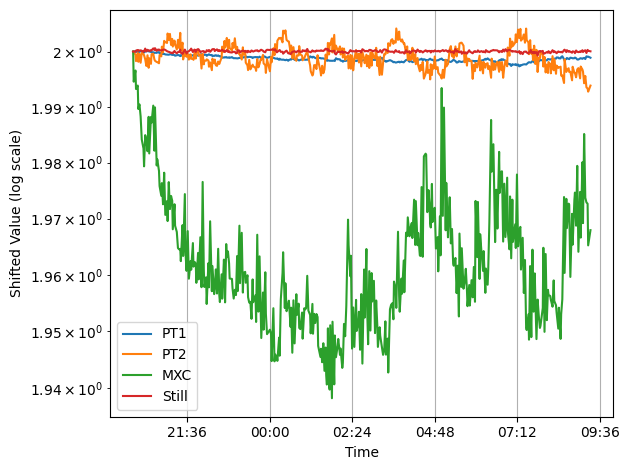

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=21,hour=20)
date2 = dt.datetime(year=2023, month=9, day=22,hour=9,minute=20)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

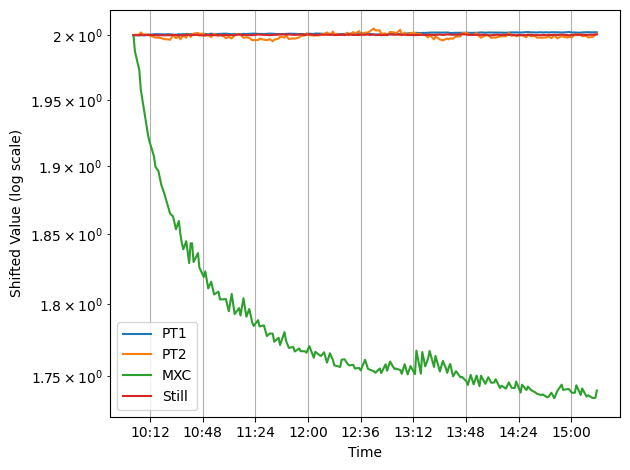

In [ ]:
date1 = dt.datetime(year=2023, month=9, day=22,hour=10)
date2 = dt.datetime(year=2023, month=9, day=22,hour=15,minute=20)
channels = ["PT1","PT2","MXC","Still"]
valuelist = []
for channel in channels:
    values, timestamps = load_data("temperature", channel, date1, date2)
    valuelist.append(values)
log_vis(timestamps,channels,valuelist)

# Anomaly_Detection prototype

A simple anomaly detection prototype was designed, so whenever a spike or severe change happened in any channel, a warning woule be produced.  
According to the number of anomalies encountered in different channels, the warning is classified to low, medium, high three levels at this stage.

## Demonstration of the prototype:

Time: 2024-01-18 14:18:53+00:00, Warning Level: Low
Time: 2024-01-19 01:51:57+00:00, Warning Level: High
Time: 2024-01-19 02:15:01+00:00, Warning Level: Medium
Time: 2024-01-19 02:55:08+00:00, Warning Level: Low
Time: 2024-01-19 12:54:58+00:00, Warning Level: Low
Time: 2024-01-19 13:24:03+00:00, Warning Level: Low
Time: 2024-01-19 13:43:06+00:00, Warning Level: Low


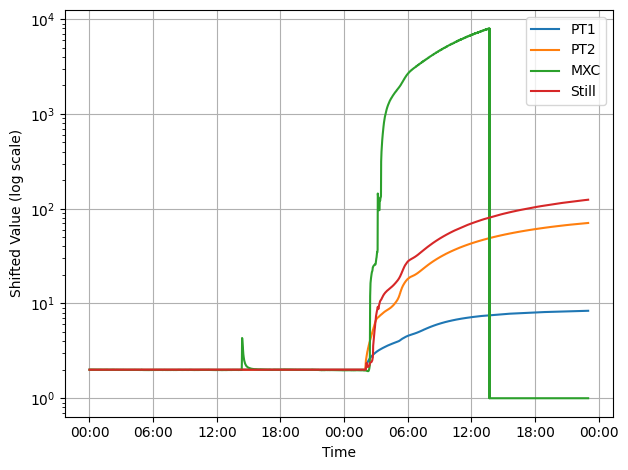

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=0)
date2 = dt.datetime(year=2024, month=1, day=19,hour=23)
def presentation(date1, date2):
    channels = ["PT1","PT2","MXC","Still"]
    valuelist = []
    all_anomalies = []
    for channel in channels:
        # The PT1 channel seems like have much more noise than the other channels,
        # so we use a larger window size for moving average
        if channel == "PT1":
            window_size = 10
        else:
            window_size = 5

        threshold = 0.05
        # Load data
        values,timestamps = load_data("temperature",channel,date1, date2)
        valuelist.append(values)
        #  Apply moving aveerage filter to denoise the signal
        MA_values, MA_timestamps = moving_average(values, timestamps, window_size)
        # find all timestamps of anomalies
        anomalies = anomaly_detection(MA_values, MA_timestamps, threshold)
        all_anomalies.append(anomalies)

    # Visualize all channels' signals
    log_vis(timestamps,channels,valuelist)

    # Sort all anomaly timestamps
    sorted_anomalies = sorted([time for sublist in all_anomalies for time in sublist])

    # Classify anomalies by frequency
    warnings = classify_anomalies(sorted_anomalies)

    # Print warnings and their levels
    for time, level in warnings:
        print(f"Time: {time}, Warning Level: {level}")

presentation(date1, date2)

During 2024/1/18 13:00 to 2024/1/18 16:00, the temperature in MXC channel experience a spike, so a low level warning is generated

Time: 2024-01-18 14:18:53+00:00, Warning Level: Low


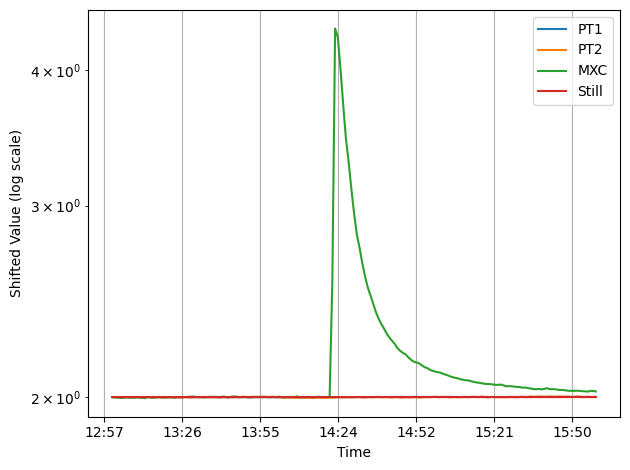

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=13)
date2 = dt.datetime(year=2024, month=1, day=18,hour=16)
presentation(date1, date2)

During 2024/1/19 1:40 to 2024/1/19 2:10, the temperature in multiple channels experience spikes, so a high level warning is generated

Time: 2024-01-19 01:51:57+00:00, Warning Level: High


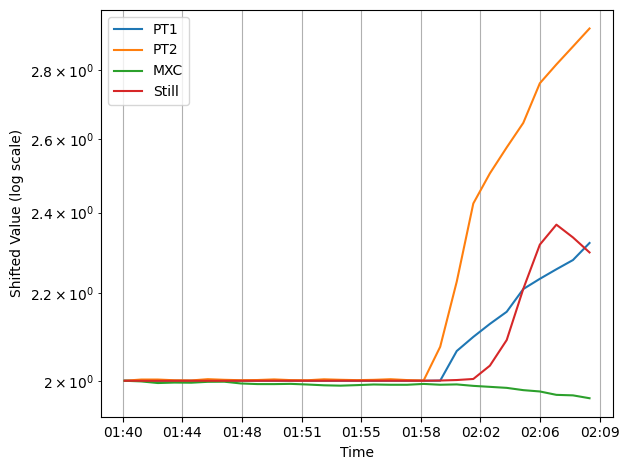

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=19,hour=1,minute=40)
date2 = dt.datetime(year=2024, month=1, day=19,hour=2,minute=10)

presentation(date1, date2)

This is the basic method for dealing anomaly detection, and can not deal the case with multi-sensors, as the dependence of multi-sensors is not considered in this basic method

## Moving Average
The moving average filter was applied in the original signal before processed in this anomaly detection prototype to remove noises. The effect of the moving average and comparison is shown in the following two plots below.

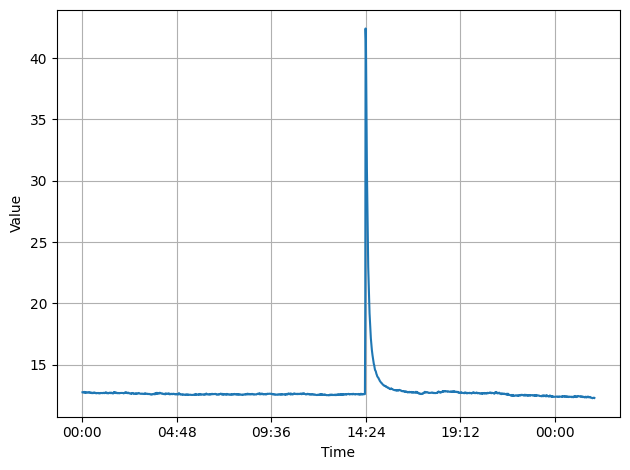

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=0)
date2 = dt.datetime(year=2024, month=1, day=19,hour=2)
temperatures, timestamps = load_data("temperature", "MXC", date1, date2)
normal_vis(timestamps,temperatures)

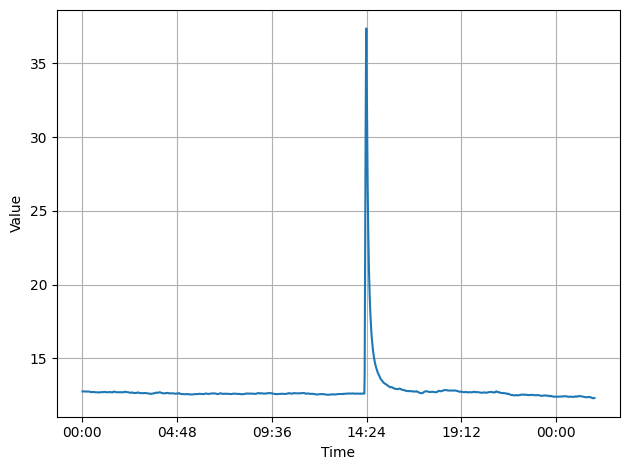

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=18,hour=0)
date2 = dt.datetime(year=2024, month=1, day=19,hour=2)
temperatures, timestamps = load_data("temperature", "MXC", date1, date2)
mv_temperatures, mv_timestamps= moving_average(temperatures, timestamps, 5)
normal_vis(mv_timestamps,mv_temperatures)

# Utility function: extract_data
This section implement a utility function used to extract and combine the data according to the given channels and time period.  

Input: desired channels to retrieve, start date, end date.  
Output: An overall result dataframe according to the input.

In [5]:
def extract_data(retrieved_channels, date1, date2, denoise=False, window_size=10, interpolate_method='time'):
    data_frames = []
    for key in retrieved_channels:
        if len(key) == 2:
            category, label = key
            df, ts = load_data(category, label, date1, date2)
            if denoise:
                df, ts = moving_average(df, ts, window_size)
            df = pd.DataFrame(index=md.num2date(ts), data={label: df})
        else:
            category, label, sublabel = key
            df, ts = load_data(category, label, date1, date2, sublabel)
            df = pd.DataFrame(index=md.num2date(ts), data={f"{label} {sublabel}": df})

        # Remove duplicates
        df = df[~df.index.duplicated(keep='first')]
        data_frames.append(df)

    # Combine all data frames
    combined_data = pd.concat(data_frames, axis=1)
    combined_data.sort_index(inplace=True)

    # Resample to 30-second intervals
    combined_data = combined_data.resample('30S').mean()

    # fill missing data with interpolation(since the sampling frequency of some sensors are not the same)
    combined_data = combined_data.interpolate(method=interpolate_method)

    combined_data.dropna(inplace=True)
    return combined_data

In [6]:
# Defined channels that want included in the resulted dataframe
# Only selected 3 channels here is for the Auto-encoder training
# These 3 channels are most correlated with MXC
retrieved_channels = [
        ("temperature", "MXC"),
        # ("temperature", "PT1"),
        # ("temperature", "PT2"),
        # ("temperature", "Still"),
        # ("pressure", "VacuumCan"),
        # ("pressure", "PumpingLine"),
        ("pressure", "CompressorOutlet"),
        # ("pressure", "CompressorInlet"),
        ("pressure", "MixtureTank"),
        # ("pressure", "VentingLine"),
        # ("cooling_water", "Compressor1", "Input"),
        # ("cooling_water", "Compressor1", "Output"),
        # ("cooling_water", "Compressor2", "Input"),
        # ("cooling_water", "Compressor2", "Output")
    ]

# Date pairs for normal data extraction
# The time period of normal data was found in the preparation section
train_date_pairs = [
    (dt.datetime(2023, 9, 2, 23), dt.datetime(2023, 9, 4, 9, 30)),
    (dt.datetime(2023, 9, 4, 18), dt.datetime(2023, 9, 5, 15, 45)),
    (dt.datetime(2023, 9, 5, 17, 40), dt.datetime(2023, 9, 12, 16)),
    (dt.datetime(2023, 9, 12, 19, 30), dt.datetime(2023, 9, 15, 11, 20)),
    (dt.datetime(2023, 9, 15, 12, 40), dt.datetime(2023, 9, 21, 17, 30)),
    (dt.datetime(2023, 9, 21, 20), dt.datetime(2023, 9, 22, 9, 20)),
    (dt.datetime(2023, 9, 22, 10), dt.datetime(2023, 9, 22, 15, 20)),
    (dt.datetime(2023, 9, 28, 22), dt.datetime(2023, 9, 29, 11, 5)),
    (dt.datetime(2023, 9, 29, 14), dt.datetime(2023, 10, 1, 8)),
    (dt.datetime(2024, 1, 13, 22), dt.datetime(2024, 1, 15, 18, 33, 31)),
    (dt.datetime(2024, 1, 16, 0), dt.datetime(2024, 1, 16, 11)),
    (dt.datetime(2024, 1, 16, 18), dt.datetime(2024, 1, 18, 14, 20)),
    (dt.datetime(2024, 1, 18, 15, 30), dt.datetime(2024, 1, 19, 1, 59))
]

whole_date_pairs = [
    (dt.datetime(2023, 8, 31, 0), dt.datetime(2023, 9, 23, 23, 59)),
    (dt.datetime(2023, 9, 26, 0), dt.datetime(2023, 10, 4, 23, 59)),
    (dt.datetime(2024, 1, 11, 0), dt.datetime(2024, 1, 19, 23, 59)),
]

In [7]:
# Using a loop to extract all normal data
normal_data_list = [extract_data(retrieved_channels, start, end, denoise = True, window_size = 5) for start, end in train_date_pairs]

# Combine all the normal data frames into one
# for fitting the standard scaler
overall_normal = pd.concat(normal_data_list)

In [8]:
overall_normal

,MXC,CompressorOutlet,MixtureTank
2023-09-02 23:01:30+00:00,18.79002,663.133333,6.001333
2023-09-02 23:02:00+00:00,18.77429,663.200000,6.001000
2023-09-02 23:02:30+00:00,18.75856,663.266667,6.000667
2023-09-02 23:03:00+00:00,18.74283,663.333333,6.000333
2023-09-02 23:03:30+00:00,18.72710,663.400000,6.000000
...,...,...,...
2024-01-19 01:52:30+00:00,12.29326,635.300000,5.004000
2024-01-19 01:53:00+00:00,12.29468,634.400000,5.002000
2024-01-19 01:53:30+00:00,12.29610,633.500000,5.002000
2024-01-19 01:54:00+00:00,12.30072,632.600000,5.002000


Draw the first piece of data under normal working

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

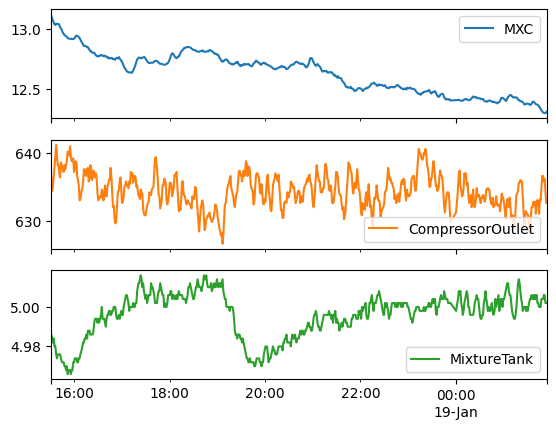

In [9]:
normal_data_list[12].plot(subplots=True)

In [10]:
# for testing
whole_data_list = [extract_data(retrieved_channels, start, end, denoise = True, window_size = 5) for start, end in whole_date_pairs]
whole_data = pd.concat(whole_data_list)

# original data without denoising
original_data_list = [extract_data(retrieved_channels, start, end) for start, end in whole_date_pairs]
original_data = pd.concat(original_data_list)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

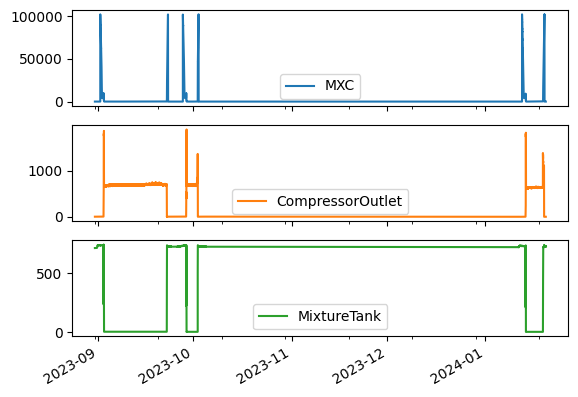

In [11]:
original_data.plot(subplots=True)

In [12]:
original_data

,MXC,CompressorOutlet,MixtureTank
2023-08-31 00:00:30+00:00,0.0,-1.480,710.0
2023-08-31 00:01:00+00:00,0.0,-1.460,710.0
2023-08-31 00:01:30+00:00,0.0,-1.440,710.0
2023-08-31 00:02:00+00:00,0.0,-1.440,710.0
2023-08-31 00:02:30+00:00,0.0,-1.440,710.0
...,...,...,...
2024-01-19 23:51:30+00:00,0.0,-3.045,723.0
2024-01-19 23:52:00+00:00,0.0,-3.030,723.0
2024-01-19 23:52:30+00:00,0.0,-3.055,723.0
2024-01-19 23:53:00+00:00,0.0,-3.080,723.0


In [ ]:
# whole_data.index.name = 'date'
# whole_data.to_csv("whole_data.csv", index=True)

In [ ]:
### View statistics of the whole_data ###
# statistics = whole_data.describe()
# statistics

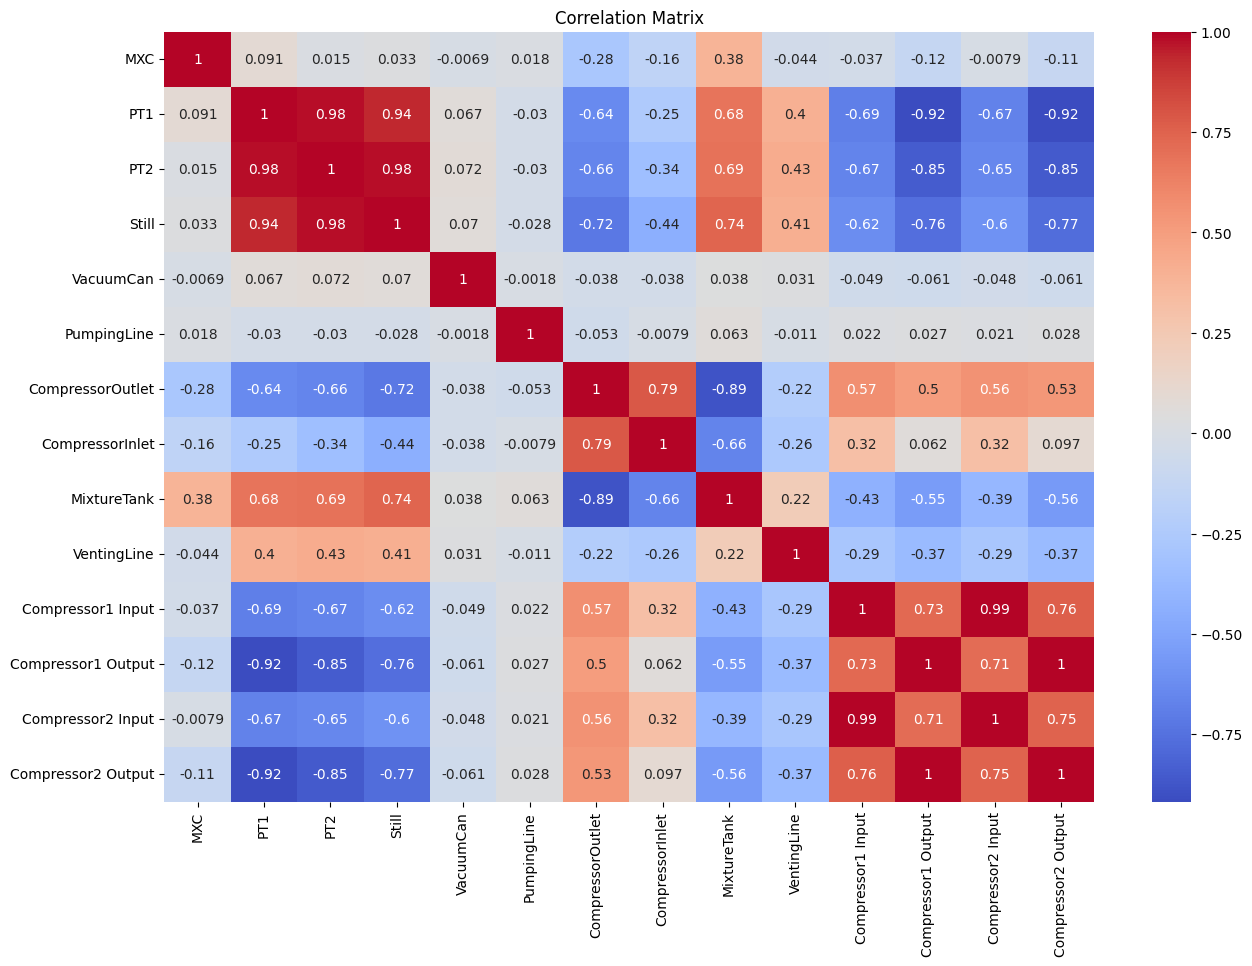

In [ ]:
## More statistics: Box plots and correlation matrix ###

# # Plot the box plot of each column
# for column in whole_data.columns:
#     plt.figure(figsize=(10, 5))
#     sns.boxplot(x=whole_data[column])
#     plt.title(f'Box plot of {column}')
#     plt.show()

# Assuming combined_data is your combined dataset
# Compute the correlation matrix
corr_matrix = whole_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Experimental Machine Learning for Time series
(no fidelity data, treat as classification problem with manual labelling).   
In order to solve the anomaly detection task, the idea first comes up is to use a machine learning method. Whereas, due to the lack of fidelity data(a value represent the quantum computer's status), we only can turn it to a classification problem. Assuming the QC's status is correlated with cooling water temperature(since only when cooling pump works, the QC can reach the normal working temperature)

In [ ]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.4 MB/s eta 0:00:00


The data was manually labelled in four states of the Quantum computer:  
notworking, small error, normal, crash down

In [ ]:
# load the manually labelled data
labels = pd.read_excel("label.xlsx")
labels

,Start time,End time,Label
0,2023-08-31 00:03:34+00:00,2023-08-31 16:50:57+00:00,notworking
1,2023-08-31 16:50:57+00:00,2023-09-01 16:26:48+00:00,small error
2,2023-09-01 16:26:48+00:00,2023-09-02 03:03:50+00:00,normal
3,2023-09-02 03:03:50+00:00,2023-09-02 18:01:21+00:00,small error
4,2023-09-02 18:01:21+00:00,2023-09-04 02:02:54+00:00,normal
...,...,...,...
94,2024-01-18 12:52:21+00:00,2024-01-18 18:29:58+00:00,normal
95,2024-01-18 18:29:58+00:00,2024-01-18 20:33:36+00:00,small error
96,2024-01-18 20:33:36+00:00,2024-01-19 01:58:27+00:00,normal
97,2024-01-19 01:58:27+00:00,2024-01-19 11:05:03+00:00,crash down


In [ ]:
# Create a new column for labels in the combined_data
whole_data['Label'] = 'unlabeled'  # Default label

# Iterate over the rows in the labels DataFrame
for index, label_row in labels.iterrows():
    # Get the boolean mask where the condition is True
    mask = (whole_data.index >= label_row['Start time']) & (whole_data.index <= label_row['End time'])

    # Apply the label to the filtered rows
    whole_data.loc[mask, 'Label'] = label_row['Label']

In [ ]:
whole_data = whole_data[whole_data['Label'] != 'unlabeled']
whole_data

,MXC,PT1,PT2,Still,VacuumCan,PumpingLine,CompressorOutlet,CompressorInlet,MixtureTank,VentingLine,Compressor1 Input,Compressor1 Output,Compressor2 Input,Compressor2 Output,Label
2023-08-31 00:03:34+00:00,0.0,293078.0,293761.0,293753.0,0.020,0.08880,-1.44,150.0,710.0,998.00,15.53500,15.58111,15.52722,15.52444,notworking
2023-08-31 00:04:57+00:00,0.0,293078.0,293761.0,293753.0,0.020,0.08870,-1.44,150.0,710.0,998.00,15.53500,15.58111,15.52722,15.52444,notworking
2023-08-31 00:05:00+00:00,0.0,293077.0,293743.0,293714.0,0.020,0.08870,-1.44,150.0,710.0,998.00,15.53500,15.58111,15.52722,15.52444,notworking
2023-08-31 00:07:34+00:00,0.0,293077.0,293743.0,293714.0,0.020,0.08870,-1.44,150.0,710.0,998.00,15.56556,15.60444,15.56056,15.55056,notworking
2023-08-31 00:08:00+00:00,0.0,293073.0,293755.0,293698.0,0.020,0.08870,-1.44,150.0,710.0,998.00,15.56556,15.60444,15.56056,15.55056,notworking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-19 22:58:26+00:00,0.0,265341.0,218089.0,203886.0,0.118,0.00321,-3.11,682.0,723.0,2.76,15.68389,15.72000,15.67889,15.64056,notworking
2024-01-19 22:58:42+00:00,0.0,265367.0,218225.0,203964.0,0.118,0.00321,-3.11,682.0,723.0,2.76,15.68389,15.72000,15.67889,15.64056,notworking
2024-01-19 22:59:21+00:00,0.0,265367.0,218225.0,203964.0,0.118,0.00321,-3.11,682.0,724.0,2.76,15.68389,15.72000,15.67889,15.64056,notworking
2024-01-19 22:59:26+00:00,0.0,265367.0,218225.0,203964.0,0.118,0.00321,-3.11,682.0,724.0,2.76,15.66611,15.71000,15.65555,15.63000,notworking


Feature engineering, calculate of feature values in every piece of the labelled data

In [ ]:
features = pd.DataFrame()
temporary = pd.DataFrame()
total_features = pd.DataFrame()
for i in range(len(whole_data) - 1):
    # Append the current row to the 'features' dataframe
    features = pd.concat([features, whole_data.iloc[[i]]],ignore_index=True)
    # Check if the label of the next row is different, or if it's the last row
    if whole_data.iloc[i + 1]['Label'] != whole_data.iloc[i]['Label'] or i == len(whole_data) - 2:

        # Calculate aggregate features and store them in 'temporary'
        for column in features.columns:
            # Avoid trying to compute these stats on the 'Label' column
            if column != 'Label':
                temporary[f'{column}_mean'] = [features[column].mean()]
                temporary[f'{column}_std'] = [features[column].std()]
                temporary[f'{column}_max'] = [features[column].max()]
                temporary[f'{column}_min'] = [features[column].min()]

        temporary['Label'] = features['Label'].iloc[0]
        # Append 'temporary' dataframe to 'total_features
        total_features = pd.concat([total_features, temporary], ignore_index=True)

        # Reset 'features' and 'temporary' dataframes for the next group of rows
        features = pd.DataFrame()
        temporary = pd.DataFrame()

total_features


,MXC_mean,MXC_std,MXC_max,MXC_min,PT1_mean,PT1_std,PT1_max,PT1_min,PT2_mean,PT2_std,...,Compressor1 Output_min,Compressor2 Input_mean,Compressor2 Input_std,Compressor2 Input_max,Compressor2 Input_min,Compressor2 Output_mean,Compressor2 Output_std,Compressor2 Output_max,Compressor2 Output_min,Label
0,0.000000,0.000000,0.0000,0.0000,292841.286577,118.287684,293079.0,292677.0,293512.655705,127.337640,...,15.53778,15.593653,0.044527,15.91555,15.50389,15.573239,0.043326,15.90000,15.47056,notworking
1,0.000000,0.000000,0.0000,0.0000,89451.714459,54709.884032,293039.0,53574.4,91856.315532,74286.186309,...,15.61722,19.096538,0.556098,20.77611,15.58667,28.989145,1.780803,30.68778,15.53500,small error
2,67917.493004,22280.606430,101899.0000,0.0000,51620.516975,1842.991690,53568.1,44737.8,16468.647335,3801.457257,...,29.48722,18.823113,0.138651,19.15222,18.47833,28.602906,0.204584,28.96166,28.02889,normal
3,6604.693453,6296.334723,33171.6000,4003.8100,36350.902419,1523.074205,44737.8,35609.7,3910.956173,996.781902,...,28.84555,18.410443,0.231862,19.85611,18.18000,27.738790,0.217498,29.04945,27.52111,small error
4,381.240910,1540.513371,9528.8300,14.4251,35831.646938,248.161043,37358.5,35701.2,3168.596384,325.098294,...,28.82778,18.392291,0.069315,18.60722,18.16722,27.802557,0.078319,28.15500,27.55444,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,13.627745,3.477726,42.4182,12.5308,36047.598993,14.070926,36072.5,36015.3,3133.087503,3.789402,...,28.91778,18.233198,0.084377,18.43222,17.91778,28.104952,0.163309,28.75778,27.70389,normal
89,12.731520,0.054513,12.8499,12.6464,36047.684444,10.977629,36069.0,36024.4,3128.898333,3.887066,...,28.90222,18.212634,0.272686,19.01833,17.83834,28.034176,0.298834,29.18833,27.65000,small error
90,12.494573,0.110298,12.7875,12.2775,36005.894332,11.972238,36030.9,35985.9,3129.947166,3.580847,...,28.74778,18.040602,0.075438,18.28556,17.68167,27.887219,0.177135,28.96667,27.51556,normal
91,36804.059899,24481.840134,78846.9000,11.9076,136003.630678,48485.077821,213188.0,35987.3,58994.395358,34991.933630,...,15.38833,24.155561,3.686657,30.45222,15.56833,25.027078,6.011359,53.44278,15.37833,crash down


standardization needed

In [ ]:
X = total_features.drop('Label', axis=1)
y = total_features['Label']

# Create a StandardScaler object
scaler = StandardScaler()
# Standardize the total_features dataframe
X_standardized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2)


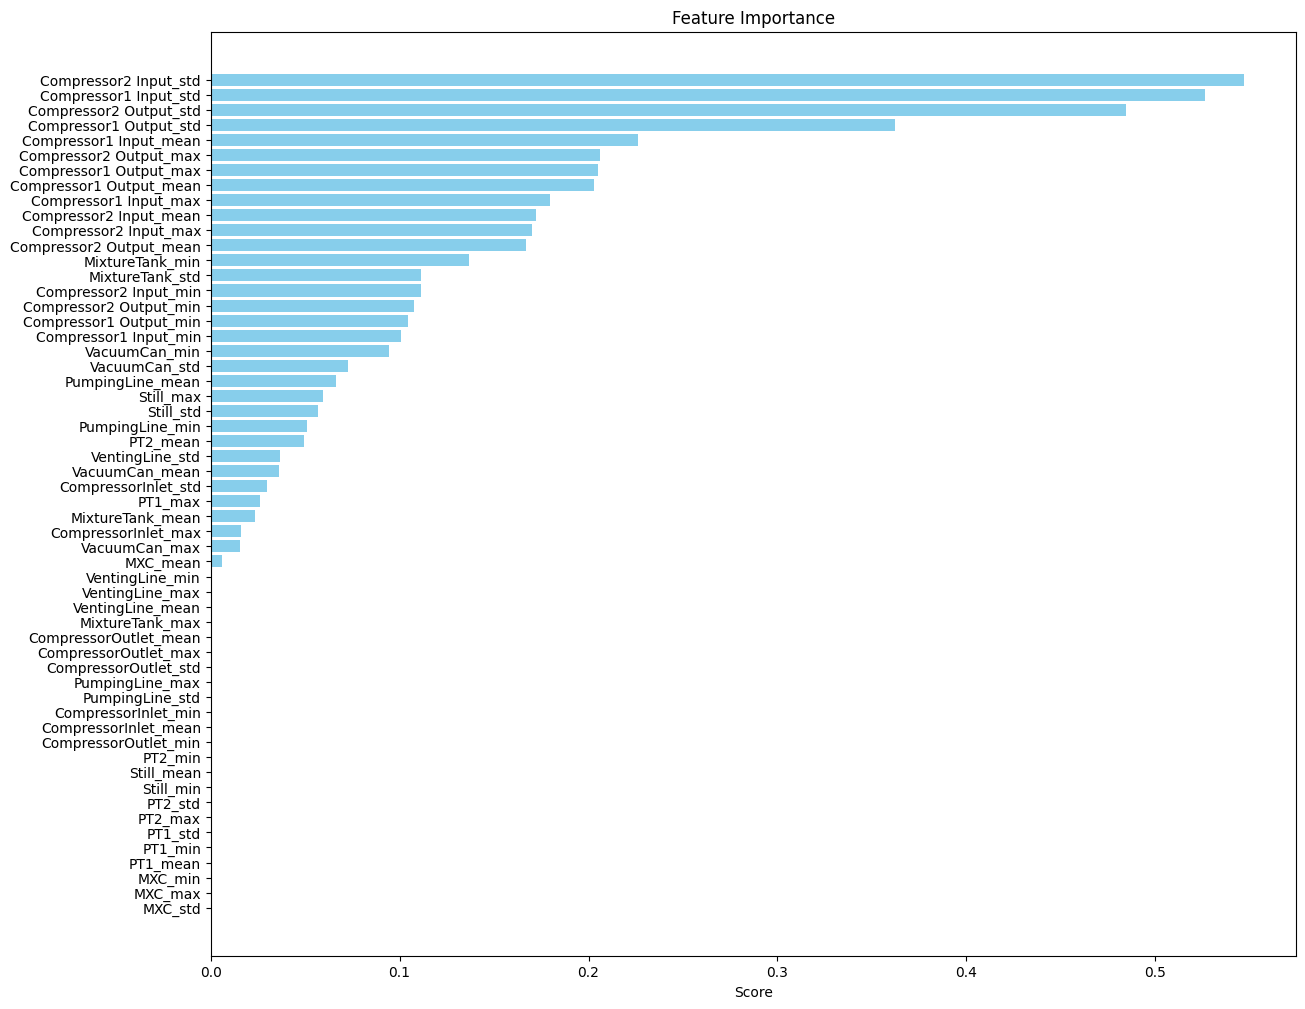

In [ ]:
skb = SelectKBest(mutual_info_classif,k=10)
skb.fit(X_train, y_train)

# Creating DataFrame of feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': skb.scores_
})

# Sorting the DataFrame based on scores
feature_scores_sorted = feature_scores.sort_values(by='Score')

# Plotting
plt.figure(figsize=(14, 12))
plt.barh(feature_scores_sorted['Feature'], feature_scores_sorted['Score'], color='skyblue')
plt.xlabel('Score')
plt.title('Feature Importance')
plt.show()

In [ ]:
RF = RandomForestClassifier()

RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

# Evaluating the model
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

      normal       0.89      0.73      0.80        11
  notworking       1.00      0.67      0.80         3
 small error       0.62      1.00      0.77         5

    accuracy                           0.79        19
   macro avg       0.84      0.80      0.79        19
weighted avg       0.84      0.79      0.79        19



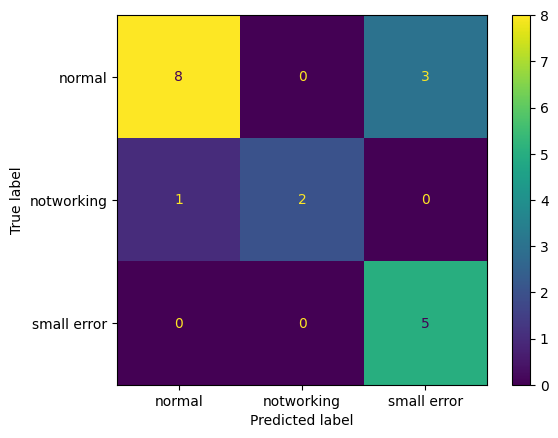

In [ ]:
class_names = ['normal', 'notworking','small error']

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

We can see the accuracy of this method is not bad: around 80%. But the problem is that this classification method need manually labelled data, which is costly, especially if huge new data come in. Additionally, this manually labelled data may not correctly represent the True status of the quantum computer(Especially here I use the cooling water temperature as the reference of labelling, and I observed it's somehow delayed compared to the change of the temperature inside the fridge, which would be more likely correlated with the actual status of the QC)

# Some other ideas

ARIMA model: is not suitable for this problem. As the model assume the data need some extent of seasonality.  

TimeGAN for synthetic data generation: doubt about its performance after several tries, hard to generate accurate synthetic data as we have very limited training data. (Somehow conflicted)

# Isolation forest & LOF
Isolation forest is a unsupervised ML approach which can learn the distribution of data directly. And by leveraging the decision tree, anomalies could be found out simply, useful for detecting threshold and linear separation of normal/abnormal.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_outlier_classifier(model, data):
  # Get labels
  labels = model.fit_predict(data)
  # Return inliers
  return data[labels == 0]

def evaluate_regressor(inliers):
  X = inliers.drop(["MXC"], axis=1)
  y = inliers[['MXC']]
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  lr = LinearRegression()
  lr.fit(X_train, y_train)
  preds = lr.predict(X_test)
  rmse = mean_squared_error(y_test, preds, squared=False)
  return rmse

In [ ]:
from itertools import product

contamination = [0.01, 0.05, 0.1, 0.2]
n_neighbors = [20, 200, 2000, 5000]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = [10, 30, 50]
metric = ['euclidean', 'manhattan', 'minkowski']

scores_lof = dict()
for cont, n_neighbors, algo, leaf_size, metric in product(contamination, n_neighbors, algorithm, leaf_size, metric):
    lof = LOF(n_neighbors=n_neighbors, algorithm=algo, contamination=cont, leaf_size=leaf_size, metric=metric)

    inliers = evaluate_outlier_classifier(lof, whole_data)

    scores_lof[(cont, n_neighbors, algo, leaf_size, metric)] = evaluate_regressor(inliers)

print(scores_lof)

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

from itertools import product
max_features = [0.6, 0.8, 1]
max_samples = [0.6, 0.8, 1]
contamination = [0.01, 0.05, 0.1, 0.2]

n_estimators = [1500,1750, 2000]
#methods = ['largest', 'mean', 'median']

scores = dict()
for n_estimators, max_features, max_samples, contamination  in product(n_estimators, max_features, max_samples, contamination):
    iforest = IForest(n_estimators = n_estimators, max_features=max_features, max_samples=max_samples, contamination=contamination)

    inliers = evaluate_outlier_classifier(iforest, whole_data)

    scores[(n_estimators, max_features, max_samples, contamination)] = evaluate_regressor(inliers)

print(scores)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


49482


In [ ]:
iforest = IForest(n_estimators = 1500, contamination=0.2, max_features=0.8, max_samples=0.8, n_jobs = -1)

ad_scaler = StandardScaler()
ad_scaler.fit(overall_normal)

#Let the trained model figure out the outliers in the whole data
labels = iforest.fit_predict(ad_scaler.transform(whole_data))
outliers = whole_data[labels == 1]
print(len(outliers))

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=11,hour=0, tzinfo=pytz.UTC)
date2 = dt.datetime(year=2024, month=1, day=20,hour=23, tzinfo=pytz.UTC)
out = outliers[(outliers.index>=date1)&(outliers.index<=date2)]
true = whole_data[(whole_data.index>=date1)&(whole_data.index<=date2)]

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

# Plotting MXC
axes[0].plot(true.index+ pd.Timedelta(minutes=5), true['MXC']+1, label='Normal')
axes[0].scatter(out.index, out['MXC'] + 1, color='red', label="Anomalies", s=5)
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title('MXC')

# Plotting CompressorOutlet
axes[1].plot(true.index+ pd.Timedelta(minutes=5), true['CompressorOutlet']+5, label='Normal')
axes[1].scatter(out.index, out['CompressorOutlet'] + 5, color='red', label="Anomalies", s=5)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].set_title('CompressorOutlet')

# Plotting MixtureTank
axes[2].plot(true.index+ pd.Timedelta(minutes=5), true['MixtureTank']+1, label='Normal')
axes[2].scatter(out.index, out['MixtureTank'] + 1, color='red', label="Anomalies", s=5)
axes[2].set_yscale('log')
axes[2].legend()
axes[2].set_title('MixtureTank')

plt.xlabel('Date')
fig.text(0.04, 0.5, 'Shifted Value (log scale)', va='center', rotation='vertical')
plt.suptitle("Isolation Forest Anomaly Detection Example")
plt.show()

In [ ]:
# Scale the data
ad_scaler = StandardScaler()
ad_scaler.fit(overall_normal)

#(0.01, 20, 'brute', 10, 'minkowski'): 14059.622931761587
# Train the Local Outlier Factor model with normal data
lof = LOF(n_neighbors=2000, contamination=0.1, algorithm='brute', leaf_size=10, metric='minkowski', novelty=True, n_jobs=-1)

# Let the trained model figure out the outliers in the whole data
labels = lof.fit_predict(ad_scaler.transform(whole_data))
outliers = whole_data[labels == 1]
print(len(outliers))

In [ ]:
date1 = dt.datetime(year=2024, month=1, day=11,hour=0, tzinfo=pytz.UTC)
date2 = dt.datetime(year=2024, month=1, day=20,hour=23, tzinfo=pytz.UTC)

out = outliers[(outliers.index >= date1) & (outliers.index <= date2)]
true = whole_data[(whole_data.index >= date1) & (whole_data.index <= date2)]

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

# Plotting MXC
axes[0].plot(true.index+ pd.Timedelta(minutes=5), true['MXC']+1, label='Normal')
axes[0].scatter(out.index, out['MXC'] + 1, color='red', label="Anomalies", s=5)
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title('MXC')

# Plotting CompressorOutlet
axes[1].plot(true.index+ pd.Timedelta(minutes=5), true['CompressorOutlet']+5, label='Normal')
axes[1].scatter(out.index, out['CompressorOutlet'] + 5, color='red', label="Anomalies", s=5)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].set_title('CompressorOutlet')

# Plotting MixtureTank
axes[2].plot(true.index+ pd.Timedelta(minutes=5), true['MixtureTank']+1, label='Normal')
axes[2].scatter(out.index, out['MixtureTank'] + 1, color='red', label="Anomalies", s=5)
axes[2].set_yscale('log')
axes[2].legend()
axes[2].set_title('MixtureTank')

plt.xlabel('Date')
fig.text(0.04, 0.5, 'Shifted Value (log scale)', va='center', rotation='vertical')
plt.suptitle("LOF Anomaly Detection Example")
plt.show()

# LSTM Auto-Encoder

An autoencoder is a type of deep neural network used to learn efficient patterns of unlabeled data through encoding-decoding process.  

Anomalies tends to have higher reconstruction loss during the process of decoding. Therefore is powerful for dealing the anomaly detection tasks.

## Preprocess

In [13]:
# 30 seconds for one time step, set to 10 here(5 min)
# slice the data to 5 min each piece for training
TIME_STEPS = 20

ad_scaler = StandardScaler()
ad_scaler.fit(overall_normal)

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

def preprocess_single_dataframe(df):

    scaled_data = ad_scaler.transform(df)
    x_train = create_sequences(scaled_data)

    return x_train

train_indices = [0, 1, 2, 3, 4]
val_indices = [5, 6, 7, 8]
test_indices= [9, 10, 11, 12]

x_train_list = [preprocess_single_dataframe(normal_data_list[i]) for i in train_indices]
x_val_list = [preprocess_single_dataframe(normal_data_list[i]) for i in val_indices]
x_test_list = [preprocess_single_dataframe(normal_data_list[i]) for i in test_indices]

# Print the shape of training data and validation data
for i, x_train in enumerate(x_train_list):
    print(f"Shape of training data from DataFrame {i+1}: {x_train.shape}")

for i, x_val in enumerate(x_val_list):
    print(f"Shape of training data from DataFrame {i+1}: {x_val.shape}")

for i, x_test in enumerate(x_test_list):
    print(f"Shape of training data from DataFrame {i+1}: {x_test.shape}")

x_train = np.concatenate(x_train_list, axis=0)
print("Combined training input shape: ", x_train.shape)

x_val = np.concatenate(x_val_list, axis=0)
print("Combined validation input shape: ", x_val.shape)

x_test = np.concatenate(x_test_list, axis=0)
print("Combined test input shape: ", x_test.shape)

Shape of training data from DataFrame 1: (4102, 20, 3)
Shape of training data from DataFrame 2: (2586, 20, 3)
Shape of training data from DataFrame 3: (19923, 20, 3)
Shape of training data from DataFrame 4: (7621, 20, 3)
Shape of training data from DataFrame 5: (17821, 20, 3)
Shape of training data from DataFrame 1: (1561, 20, 3)
Shape of training data from DataFrame 2: (602, 20, 3)
Shape of training data from DataFrame 3: (1536, 20, 3)
Shape of training data from DataFrame 4: (5012, 20, 3)
Shape of training data from DataFrame 1: (5319, 20, 3)
Shape of training data from DataFrame 2: (1297, 20, 3)
Shape of training data from DataFrame 3: (5293, 20, 3)
Shape of training data from DataFrame 4: (1231, 20, 3)
Combined training input shape:  (52053, 20, 3)
Combined validation input shape:  (8711, 20, 3)
Combined test input shape:  (13140, 20, 3)


In [14]:
test_list = [preprocess_single_dataframe(df) for df in whole_data_list]

# Print the shape of test data
for i, x_test in enumerate(test_list):
    print(f"Shape of training data from DataFrame {i+1}: {x_test.shape}")
test_combined = np.concatenate(test_list, axis=0)
print("Combined training input shape: ", test_combined.shape)

Shape of training data from DataFrame 1: (69075, 20, 3)
Shape of training data from DataFrame 2: (25874, 20, 3)
Shape of training data from DataFrame 3: (25880, 20, 3)
Combined training input shape:  (120829, 20, 3)


## Defining learning rate scheduler

In [15]:
def lr_warmup_cosine_decay(global_step, warmup_steps, hold = 0, total_steps=0, start_lr=0.0, target_lr=1e-3):

        # warm_steps: number of steps linearly increase to the maximum learning rate
        # total_steps: number of steps drop down back to the start learning rate
        # global_step: current number of steps
        learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

        # target LR: Desired maximum lr
        warmup_lr = target_lr * (global_step / warmup_steps)

        # hold: number of steps keep for the target LR
        if hold > 0:
            learning_rate = np.where(global_step > warmup_steps + hold,
                                    learning_rate, target_lr)

        learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)

        return learning_rate

In [16]:
#Cosine decay warmup
# referenced from https://stackabuse.com/learning-rate-warmup-with-cosine-decay-in-keras-and-tensorflow/
class WarmupCosineDecay(keras.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 0
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []

    # append the value of learning rate in the list for review
    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = self.model.optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)
        K.set_value(self.model.optimizer.lr, lr)

    # print learning rate at end of the epoch
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr.numpy()
        print(f" Learning rate: {lr}")

## Temporary model for presentation & experiment

In [ ]:
timesteps = x_train.shape[1]
num_features = x_train.shape[2]

model = keras.Sequential([
    layers.Input(shape=(timesteps, num_features)),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001))),
    layers.BatchNormalization(),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.1),
    layers.RepeatVector(timesteps),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.0001))),
    layers.Dropout(0.1),
    layers.TimeDistributed(layers.Dense(num_features))
])

init_weights = model.get_weights()

optimizer = tf.keras.optimizers.Adam(clipnorm=0.4, weight_decay=1e-4)

model.compile(optimizer = optimizer, loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 10, 256)           133120    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 10, 256)           1024      
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 128)           0         
 r)                                                     

In [ ]:
batch_size = 256
epochs = 100

keras.backend.clear_session()
model.set_weights(init_weights)

# save the best weight of model locally
class SaveBestModel(keras.callbacks.Callback):
    def __init__(self):
        super(SaveBestModel, self).__init__()
        self.best_weights = None
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_weights = self.model.get_weights()  # Save the current best weights
            print(f" val_loss improved to {val_loss:.4f}, saving model weights.")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)  # Restore the best weights
            print(" Training complete. Best model weights restored.")

total_steps = len(x_train_combined)/batch_size*50
warmup_steps = int(0.05*total_steps)

lr_callback = WarmupCosineDecay(
                            total_steps=total_steps,
                            warmup_steps=warmup_steps,
                            hold=int(warmup_steps/2),
                            start_lr=1e-5,
                            target_lr=1e-3)

history = model.fit(
    x_train_combined,
    x_train_combined,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[
        SaveBestModel(),
        lr_callback,
    ],
)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.2335 val_loss improved to 0.2489, saving model weights.
 Learning rate: 0.0003167420800309628
71/71 [==============================] - 23s 163ms/step - loss: 0.2335 - val_loss: 0.2489
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.0681 val_loss improved to 0.2099, saving model weights.
 Learning rate: 0.0006380090489983559
71/71 [==============================] - 9s 127ms/step - loss: 0.0681 - val_loss: 0.2099
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.0601 val_loss improved to 0.1893, saving model weights.
 Learning rate: 0.0009592760470695794
71/71 [==============================] - 9s 127ms/step - loss: 0.0601 - val_loss: 0.1893
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 0.0493 val_loss improved to 0.0673, saving model weights.
 Learning rate: 0.0010000000474974513
71/71 [==============================] - 9s 128ms/step - loss: 0.0493 - 

validation loss result of moving average denoising with 5 window size: 0.07468

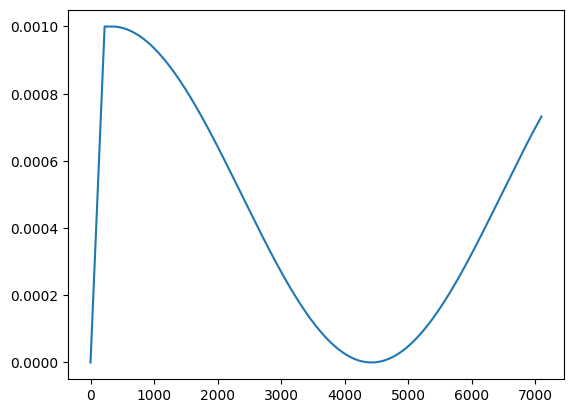

In [ ]:
lrs = lr_callback.lrs
plt.plot(lrs)

## Visualization of the result

In [17]:
# Defined as a function for reuse later
def autoencoder_result_visualization(
                                    # history,
                                    model):

   # Plot the training and validation loss
    # plt.plot(history.history["loss"], label="Training Loss")
    # plt.plot(history.history["val_loss"], label="Validation Loss")
    # plt.title('Model Loss over epoch')
    # plt.legend()
    # plt.show()

    # Get predicted data from the autoencoder
    x_val_pred = model.predict(x_val)
    # Calculate the MAE loss for training samples
    train_mae_loss = np.mean(np.mean(np.abs(x_val_pred - x_val), axis=-1),axis=-1)

    # Plot a histogram of training MAE loss
    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Validation MAE loss")
    plt.ylabel("No of samples")
    plt.title('Distribution of validation MAE loss')
    plt.show()

    # Set the maximum train loss as the threshold for anomaly detection
    print(f"max MAE loss = {np.max(train_mae_loss)}")
    threshold = np.percentile(train_mae_loss, 81.9)
    #threshold = np.max(train_mae_loss)
    #threshold = np.percentile(densities, 5)
    print("Reconstruction error threshold: ", threshold)

    # Plot the original and predicted sequences for the first training sample
    plt.plot(x_val[1000][:,0], label="origin")
    plt.plot(x_val_pred[1000][:,0], label="reconstruction")
    plt.xlabel("Value")
    plt.ylabel("Time")
    plt.title("Example training sample origin and reconstruction")
    plt.legend()
    plt.show()

    # Get predicted data from the autoencoder for test data
    test_pred = model.predict(test_combined)
    # Calculate the Mean Absolute Error (MAE) loss for test samples
    test_mae_loss = np.mean(np.mean(np.abs(test_pred - test_combined), axis=-1),axis=-1)

    # Plot a histogram of test MAE loss
    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.title('Distribution of Test MAE loss')
    plt.show()

    # Detect anomalies based on the threshold
    anomalies = test_mae_loss > threshold
    print("Number of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))

    # First test sample of first channel
    plt.plot(test_combined[2450][:,0], label="origin")
    plt.plot(test_pred[2450][:,0], label="reconstruction")
    plt.xlabel("Value")
    plt.ylabel("Time")
    plt.title("Example test sample origin and reconstruction")
    plt.legend()
    plt.show()

    # Find indices of anomalous data points
    anomalous_data_indices = []
    for data_idx in range(TIME_STEPS - 1, len(whole_data)):
        if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)

    # Plot anomalies on the original
    df_subset = original_data.iloc[anomalous_data_indices]
    date1 = dt.datetime(year=2024, month=1, day=11,hour=0, tzinfo=pytz.UTC)
    date2 = dt.datetime(year=2024, month=1, day=20,hour=23, tzinfo=pytz.UTC)
    true = original_data[(original_data.index>=date1)&(original_data.index<=date2)]
    out = df_subset[(df_subset.index>=date1)&(df_subset.index<=date2)]

    fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
    # Plotting MXC
    axes[0].plot(true.index-pd.Timedelta(minutes=5), true['MXC']+1, label='Normal')
    axes[0].scatter(out.index, out['MXC'] + 1, color='red', label="Anomalies", s=5)
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].set_title('MXC')

    # Plotting CompressorOutlet
    axes[1].plot(true.index- pd.Timedelta(minutes=5), true['CompressorOutlet']+5, label='Normal')
    axes[1].scatter(out.index, out['CompressorOutlet'] + 5, color='red', label="Anomalies", s=5)
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].set_title('CompressorOutlet')

    # Plotting MixtureTank
    axes[2].plot(true.index- pd.Timedelta(minutes=5), true['MixtureTank']+1, label='Normal')
    axes[2].scatter(out.index, out['MixtureTank'] + 1, color='red', label="Anomalies", s=5)
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].set_title('MixtureTank')

    plt.xlabel('Date')
    fig.text(0.04, 0.5, 'Shifted Value (log scale)', va='center', rotation='vertical')
    plt.suptitle("Auto-Encoder Anomaly Detection Example")
    plt.show()

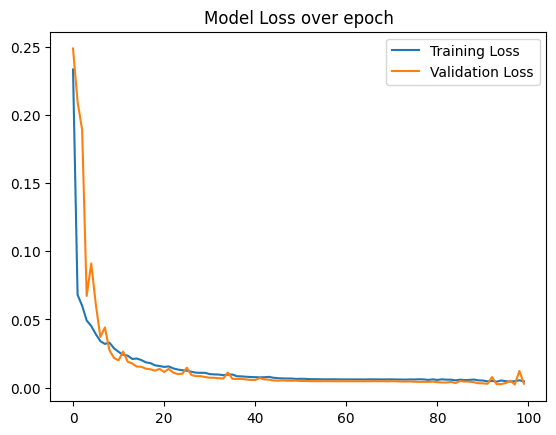

708/708 [==============================] - 11s 15ms/step


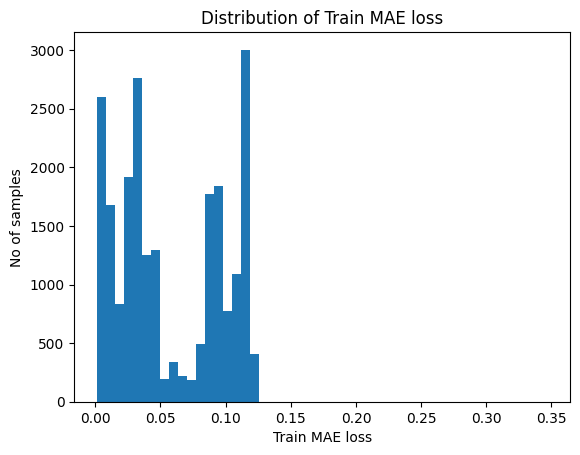

Reconstruction error threshold:  0.3472480051967176


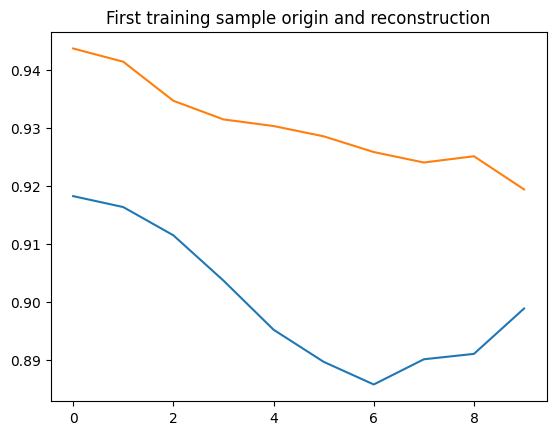

1188/1188 [==============================] - 17s 15ms/step


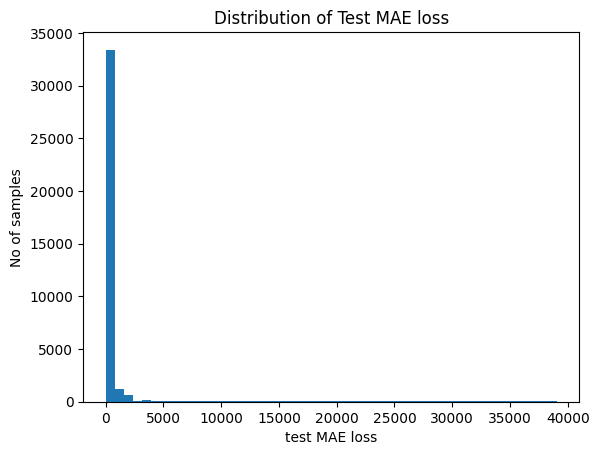

Number of anomaly samples:  13872
Indices of anomaly samples:  (array([    0,     1,     2, ..., 38012, 38013, 38014]),)


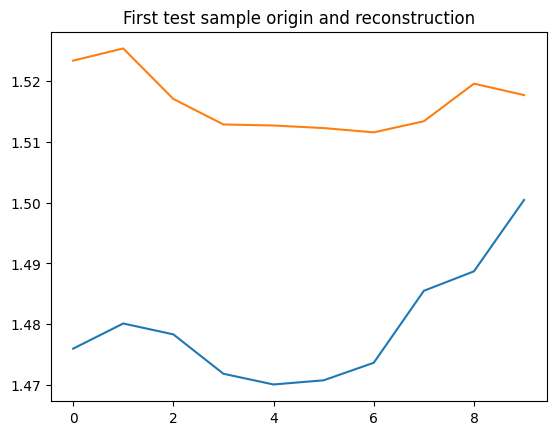

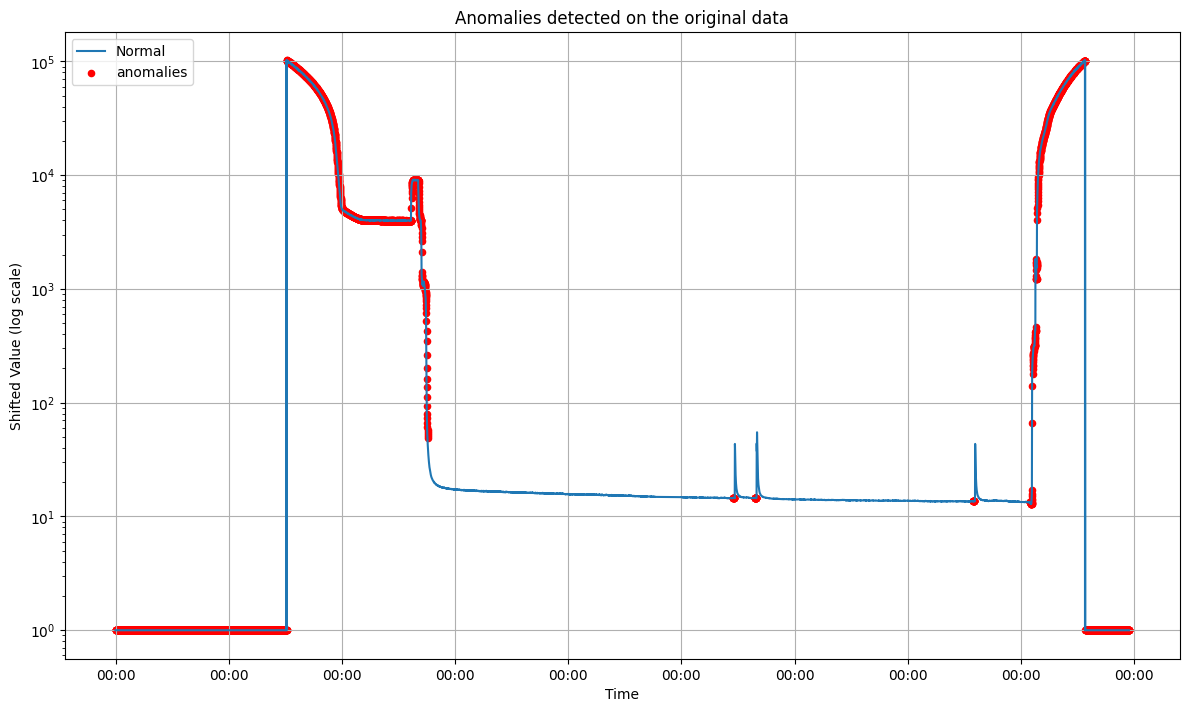

In [ ]:
autoencoder_result_visualization(history, model)

## Define an hypermodel for hyperparameter search

In [18]:
class LSTM_AD_HyperModel(HyperModel):
    def __init__(self, num_samples, window_size, num_features):
        self.num_samples = num_samples
        self.window_size = window_size
        self.num_features = num_features

    def build(self, hp):

        use_conv = hp.Boolean('use_conv')
        conv_filters = hp.Choice('conv_filters', [32, 64, 128, 256], parent_name= 'use_conv', parent_values=[True])
        gaussian = hp.Float('gaussian', min_value=0, max_value=0.4, step=0.01)
        use_bidirectional = hp.Boolean('use_bidirectional')
        encode_lstm_layers = hp.Int('num_lstm_layers_en', min_value=1, max_value=3, step=1)
        decode_lstm_layers = hp.Int('num_lstm_layers_de', min_value=1, max_value=3, step=1)
        batch_norm = hp.Boolean('use_batchnorm')
        units = hp.Choice('lstm_units', [32, 64, 128, 256])
        dropout1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.05)
        regularizer1 = hp.Float('regularizer_1', min_value=0.0001, max_value=0.01, sampling='LOG')
        dropout2 = hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.05)
        regularizer2 = hp.Float('regularizer_2', min_value=0.0001, max_value=0.01, sampling='LOG')

        model = tf.keras.models.Sequential()
        model.add(layers.Input(shape=(self.window_size, self.num_features)))
        model.add(layers.GaussianNoise(gaussian))

        if use_conv:
          model.add(layers.Conv1D(filters=conv_filters, kernel_size=3, padding='causal', activation='relu'))
          model.add(layers.MaxPooling1D(pool_size=2))
          model.add(layers.Conv1D(filters=conv_filters//2, kernel_size=3, padding='causal', activation='relu'))
          model.add(layers.MaxPooling1D(pool_size=2))

        for i in range(encode_lstm_layers):
            if use_bidirectional:
                model.add(layers.Bidirectional(layers.LSTM(
                    units=units//(2**i),
                    return_sequences=True if i < encode_lstm_layers - 1 else False,
                    kernel_regularizer = tf.keras.regularizers.l2(regularizer1)
                )))
            else:
                model.add(layers.LSTM(
                    units=units//(2**i),
                    return_sequences=True if i < encode_lstm_layers - 1 else False,
                    kernel_regularizer = tf.keras.regularizers.l2(regularizer1)
                ))
                model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout1))

        model.add(layers.RepeatVector(self.window_size))

        for i in range(decode_lstm_layers):
              if use_bidirectional:
                  model.add(layers.Bidirectional(layers.LSTM(
                      units=units//(2**i),
                      return_sequences=True,
                      kernel_regularizer = tf.keras.regularizers.l2(regularizer2)
                  )))
              else:
                  model.add(layers.LSTM(
                      units=units//(2**i),
                      return_sequences=True,
                      kernel_regularizer = tf.keras.regularizers.l2(regularizer2)
                  ))
                  model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout2))

        model.add(layers.TimeDistributed(layers.Dense(self.num_features)))

        optimizer = tf.keras.optimizers.Adam(
            clipnorm=hp.Float('clipnorm', min_value=0.1, max_value=1.0, step=0.1),
            weight_decay=hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='LOG')
        )
        model.compile(optimizer=optimizer, loss='mse')

        # learning rate schedular hyperparameters
        hp.Choice("batch_size", [128, 256, 512, 1024, 2048])
        start_lr = hp.Float('start_lr', min_value=1e-7, max_value=1e-3, sampling='LOG')
        target_lr = hp.Float('target_lr', min_value=start_lr, max_value=1e-1, sampling='LOG')
        hp.Int("epochs_per_period", min_value=10, max_value = 200, step=20)

        return model

    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp.get("batch_size")
        start_lr = hp.get("start_lr")
        target_lr = hp.get("target_lr")
        epochs_per_period = hp.get("epochs_per_period")

        total_steps = self.num_samples/batch_size * epochs_per_period
        warmup_steps = int(0.05*total_steps)

        # reuse the cos decay learning scheduler again
        lr_callback = WarmupCosineDecay(
                                    total_steps=total_steps,
                                    warmup_steps=warmup_steps,
                                    hold=int(warmup_steps/2),
                                    start_lr=start_lr,
                                    target_lr=target_lr)

        # append callback
        kwargs["callbacks"].append(lr_callback)

        return model.fit(
            *args,
            batch_size= batch_size,
            **kwargs,
        )

In [ ]:
# Instantiate the hypermodel
num_samples = x_train.shape[0]
timesteps = x_train.shape[1]
num_features = x_train.shape[2]

lstm_ad = LSTM_AD_HyperModel(num_samples, timesteps, num_features)

keras.backend.clear_session()
#keras.mixed_precision.set_global_policy('mixed_float16')

tuner = BayesianOptimization(
    lstm_ad,
    objective='val_loss',
    max_trials=100,
    directory='hypermodel',
    overwrite=False,
    project_name='lstm_ad'
)

# start the hyperparameter search
tuner.search(x_train,
             x_train,
             epochs=500,
             validation_data=(x_val,x_val),
             callbacks=[
                 keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, mode="min", restore_best_weights=True)
                 ]
             )

## Load the Specific Tuner

In [19]:
num_samples = x_train.shape[0]
timesteps = x_train.shape[1]
num_features = x_train.shape[2]
hypermodel = LSTM_AD_HyperModel(num_samples, timesteps, num_features)

In [20]:
def load_best_tuner(model_name, project_name):
  tuner = BayesianOptimization(
      model_name,
      objective='val_loss',
      max_trials=60,
      directory='hypermodel',
      overwrite=False,
      project_name=project_name
  )
  # Get the best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  print("Best Hyperparameters:")
  print(best_hps.values)
  # reconstruct the model with best hyperparameters
  model = tuner.hypermodel.build(best_hps)

  # load best model weights from the folder
  best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
  best_trial_id = best_trial.trial_id
  best_model_path = f"{tuner.project_dir}/trial_{best_trial_id}/checkpoint"
  model.load_weights(best_model_path)
  model.summary()
  return model

In [22]:
model = load_best_tuner(hypermodel, 'lstm_ad')

Reloading Tuner from hypermodel/lstm_ad/tuner0.json
Best Hyperparameters:
{'use_conv': False, 'gaussian': 0.12, 'use_bidirectional': False, 'num_lstm_layers_en': 1, 'num_lstm_layers_de': 1, 'use_batchnorm': True, 'lstm_units': 256, 'dropout_rate_1': 0.1, 'regularizer_1': 0.004247017362756204, 'dropout_rate_2': 0.1, 'regularizer_2': 0.0016990645127459008, 'clipnorm': 0.30000000000000004, 'weight_decay': 2.0887950879193552e-05, 'batch_size': 128, 'start_lr': 4.525723134781276e-05, 'target_lr': 0.00043346427108835787, 'epochs_per_period': 90}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (Gaussian  (None, 20, 3)             0         
 Noise)                                                          
                                                                 
 lstm_2 (LSTM)               (None, 256)               266240    
                                    

In [23]:
model.save("AD_model")

273/273 [==============================] - 8s 24ms/step


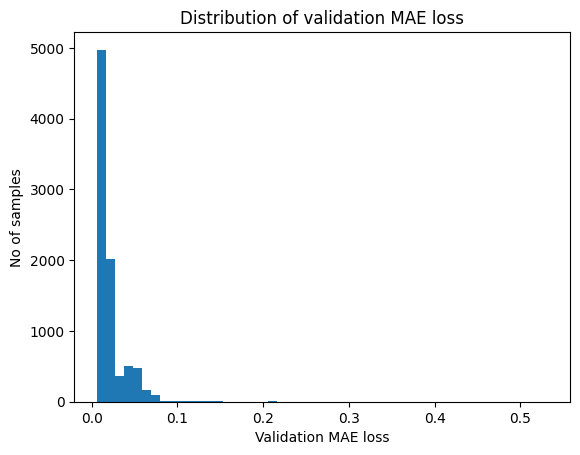

max MAE loss = 0.5319870097377748
Reconstruction error threshold:  0.03282384411659242


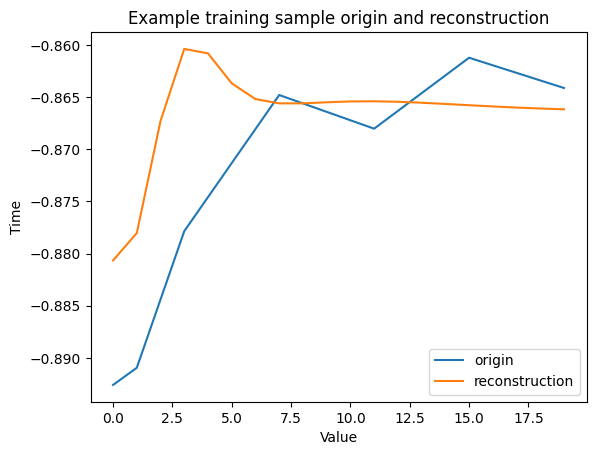

3776/3776 [==============================] - 93s 25ms/step


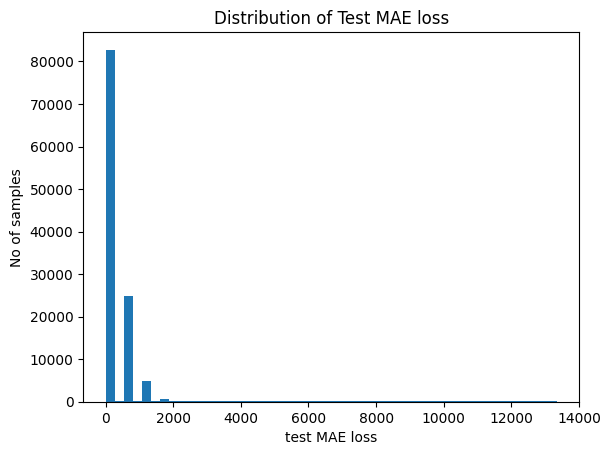

Number of anomaly samples:  46421
Indices of anomaly samples:  (array([     0,      1,      2, ..., 120826, 120827, 120828]),)


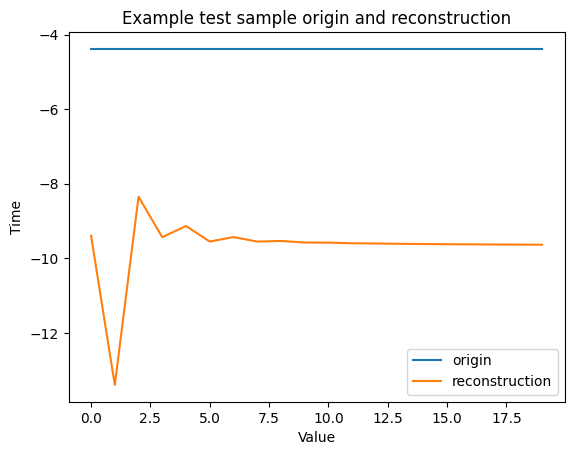

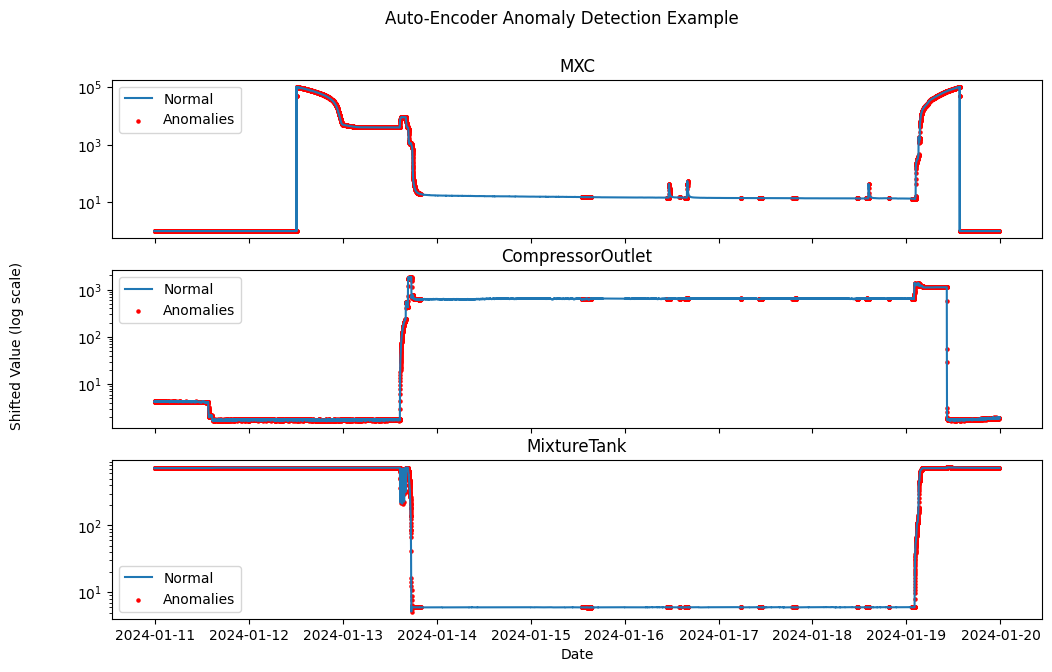

In [24]:
autoencoder_result_visualization(model)

## Bench Mark

In [ ]:
from sklearn.metrics import auc
def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])
    n_samples = s_X.shape[0]
    s_X_unique = np.unique(s_X)
    EM_t[0] = 1.
    for u in s_X_unique:
      if (s_unif >= u).sum() > n_generated / 1000:
        EM_t = np.maximum(EM_t, 1/ n_samples * (s_X > u).sum() -
                          t * (s_unif > u).sum() / n_generated
                          * volume_support)
    amax = -1
    AUC = auc(t[:amax], EM_t[:amax])
    plt.plot(t[:amax], EM_t[:amax], label='EM_t')
    plt.xlabel('Time')
    plt.ylabel('EM_t')
    plt.title('EM_t over time')
    plt.legend()
    plt.grid(True)
    plt.show()
    return AUC, EM_t, amax


def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]
    s_X_argsort = s_X.argsort()
    mass = 0
    cpt = 0
    u = s_X[s_X_argsort[-1]]
    mv = np.zeros(axis_alpha.shape[0])
    for i in range(axis_alpha.shape[0]):
        # pdb.set_trace()
        while mass < axis_alpha[i]:
            cpt += 1
            u = s_X[s_X_argsort[-cpt]]
            mass = 1. / n_samples * cpt  # sum(s_X > u)
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support
    return auc(axis_alpha, mv), mv

In [ ]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

In [ ]:
bench_test_iforest.shape

In [ ]:
s_unif_autoencoder

In [ ]:
s_X_iforest

In [ ]:
max_features = 3
n_generated = 2000
alpha_min = 0.7
alpha_max = 0.999
t_max = 0.7

au_train_list = [preprocess_single_dataframe(df) for df in normal_data_list]
au_train = np.concatenate(au_train_list, axis=0)
print("Combined training input shape: ", au_train.shape)

em_iforest, mv_iforest = 0, 0
em_lof, mv_lof = 0, 0
em_autoencoder, mv_autoencoder = 0, 0

bench_train = ad_scaler.transform(overall_normal)
lim_inf = bench_train.min(axis=0)
lim_sup = bench_train.max(axis=0)
volume_support = (lim_sup - lim_inf).prod()
if volume_support > 0:
    t = np.arange(0, 100 / volume_support, 0.001 / volume_support)
    axis_alpha = np.arange(alpha_min, alpha_max, 0.001)
    unif = np.random.uniform(lim_inf, lim_sup,
                              size=(n_generated, max_features))

    s_X_iforest = iforest.decision_function(bench_train)
    s_unif_iforest = iforest.decision_function(unif)

    s_X_lof = lof.decision_function(bench_train)
    s_unif_lof = lof.decision_function(unif)

    unif_au = preprocess_single_dataframe(unif)
    X_pred = model.predict(au_train)
    s_X_autoencoder = np.mean(np.mean(np.abs(X_pred - au_train), axis=-1),axis=-1)
    unif_pred = model.predict(unif_au)
    s_unif_autoencoder = np.mean(np.mean(np.abs(unif_pred - unif_au), axis=-1),axis=-1)

    s_X_iforest_scaled = min_max_scaling(-s_X_iforest)
    s_unif_iforest_scaled = min_max_scaling(-s_unif_iforest)
    s_X_autoencoder_scaled = min_max_scaling(-s_X_autoencoder)
    s_unif_autoencoder_scaled = min_max_scaling(-s_unif_autoencoder)
    s_X_lof_scaled = min_max_scaling(-s_X_lof)
    s_unif_lof_scaled = min_max_scaling(-s_unif_lof)

    em_iforest_auc, em_iforest, amax_iforest = em(t, t_max, volume_support, s_unif_iforest_scaled, s_X_iforest_scaled, n_generated)
    mv_iforest_auc, mv_iforest = mv(axis_alpha, volume_support, s_unif_iforest_scaled, s_X_iforest_scaled, n_generated)

    em_lof_auc, em_lof, amax_lof = em(t, t_max, volume_support, s_unif_lof_scaled, s_X_lof_scaled, n_generated)
    mv_lof_auc, mv_lof = mv(axis_alpha, volume_support, s_unif_lof_scaled, s_X_lof_scaled, n_generated)

    em_autoencoder_auc, em_autoencoder, amax_autoencoder = em(t, t_max, volume_support, s_unif_autoencoder_scaled, s_X_autoencoder_scaled, n_generated)
    mv_autoencoder_auc, mv_autoencoder = mv(axis_alpha, volume_support, s_unif_autoencoder_scaled, s_X_autoencoder_scaled, n_generated)

    # Plot EM_t results
    plt.figure()
    plt.plot(t, em_iforest, label='Isolation Forest EM_t')
    plt.plot(t, em_lof, label='Local Outlier Factor EM_t')
    plt.plot(t, em_autoencoder, label='Autoencoder EM_t')
    plt.xlabel('Time')
    plt.ylabel('EM_t')
    plt.title('EM_t over Time')
    plt.legend()
    plt.show()

    # Plot MV results
    plt.figure()
    plt.plot(axis_alpha, mv_iforest, label='Isolation Forest MV')
    plt.plot(axis_alpha, mv_lof, label='Local Outlier Factor MV')
    plt.plot(axis_alpha, mv_autoencoder, label='Autoencoder MV')
    plt.xlabel('Alpha')
    plt.ylabel('MV')
    plt.title('MV over Alpha')
    plt.legend()
    plt.show()

print(f"Isolation Forest EM: {em_iforest_auc}, MV: {mv_iforest_auc}")
print(f"Local Outlier Factor EM: {em_lof_auc}, MV: {mv_lof_auc}")
print(f"Autoencoder EM: {em_autoencoder_auc}, MV: {mv_autoencoder_auc}")

# Multi-variate Times series forecasting

## Preprocessing

In [ ]:
horizon = 20 # how far to predict forward
window_size = 60 # how far to lookback

forecast_scaler = MinMaxScaler()
scaled_data = forecast_scaler.fit_transform(whole_data)

def windowed_dataset(df, window_size, horizon):
    X = []
    y = []
    # iterate through the dataset and create the windowed dataset
    for i in range(len(df) - window_size - horizon +1):
        # data across the window size is the feature
        feature = [a for a in df[i :i+window_size]]
        X.append(feature)
        # next value after the window size is the label
        label = df[i+window_size:i+window_size+horizon]
        y.append(label)
    return np.array(X), np.array(y)

X, y = windowed_dataset(scaled_data, window_size, horizon)
X.shape, y.shape

((120807, 60, 3), (120807, 20, 3))

In [ ]:
def train_val_test_split(X, y, train_size, val_size):
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, 69015, 27273)

## N-BEATS algorithm

In [ ]:
# Referenced from https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb#scrollTo=llwhXCn9-hQt

# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               window_size: int,
               features: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               dropout_rate: float,
               activation: str,
               **kwargs):
    super().__init__(**kwargs)
    self.window_size = window_size
    self.features = features
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    self.dropout_rate = dropout_rate
    self.activation = activation
    self.hidden = []

    self.flatten = tf.keras.layers.Flatten()
    for _ in range(n_layers):
      self.hidden.append(tf.keras.layers.Dense(n_neurons, activation=self.activation))
      self.hidden.append(tf.keras.layers.Dropout(dropout_rate)) # add dropout after each hidden layer
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")
    # Reshape the output to multivariate
    self.reshape = tf.keras.layers.Reshape((self.window_size+self.horizon, self.features))

  def call(self, inputs): # the call method is what runs when the layer is called
    x = self.flatten(inputs)
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    theta = self.reshape(theta)
    backcast, forecast = theta[:, :self.window_size, :], theta[:, -self.horizon:, :]
    return backcast, forecast

In [ ]:
class NBEATS_Forecasting_HyperModel(HyperModel):
    def __init__(self, num_samples, window_size, features, theta_size, horizon):
        self.num_samples = num_samples
        self.window_size = window_size
        self.features = num_features
        self.theta_size = theta_size
        self.horizon = horizon

    def build(self, hp):
        neurons = hp.Choice('neurons', [16, 32, 64, 128, 256])
        layers = hp.Int('layers', min_value=1, max_value=5)
        stacks = hp.Int('stacks', min_value=1, max_value=5)

        stack_input = tf.keras.layers.Input(shape=(self.window_size, self.features), name="stack_input")
        dropout_rate = hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.05)
        activation = hp.Choice('activation', ['relu', 'leaky_relu', 'elu'])

        nbeats_block_layer = NBeatsBlock(window_size=self.window_size,
                                         features=self.features,
                                         theta_size=self.theta_size,
                                         horizon=self.horizon,
                                         n_neurons=neurons,
                                         n_layers=layers,
                                         dropout_rate=dropout_rate,
                                         activation=activation)

        backcast, forecast = nbeats_block_layer(stack_input)
        backcast_reshaped = tf.keras.layers.Reshape((self.window_size, self.features))(backcast)
        residuals = tf.keras.layers.subtract([stack_input, backcast_reshaped], name=f"subtract_00")

        for i in range(stacks - 1):
            backcast, block_forecast = NBeatsBlock(
                window_size=self.window_size,
                features=self.features,
                theta_size=self.theta_size,
                horizon=self.horizon,
                n_neurons=neurons,
                n_layers=layers,
                dropout_rate=dropout_rate,
                activation=activation
            )(residuals)

            backcast_reshaped = tf.keras.layers.Reshape((self.window_size, self.features))(backcast)
            residuals = tf.keras.layers.subtract([residuals, backcast_reshaped], name=f"subtract_{i + 1}")
            forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i + 1}")

        model = tf.keras.Model(inputs=stack_input, outputs=forecast)

        optimizer = tf.keras.optimizers.Adam(
            clipnorm=hp.Float('clipnorm', min_value=0.1, max_value=1.0, step=0.1),
            weight_decay=hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='LOG')
        )

        model.compile(
            optimizer=optimizer,
            loss='mse'
        )

        # learning rate schedular hyperparameters
        hp.Choice("batch_size", [128, 256, 512, 1024, 2048])
        start_lr = hp.Float('start_lr', min_value=1e-7, max_value=1e-3, sampling='LOG')
        target_lr = hp.Float('target_lr', min_value=start_lr, max_value=1e-1, sampling='LOG')
        hp.Int("epochs_per_period", min_value=10, max_value = 200, step=20)

        return model

    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp.get("batch_size")
        start_lr = hp.get("start_lr")
        target_lr = hp.get("target_lr")
        epochs_per_period = hp.get("epochs_per_period")

        total_steps = self.num_samples/batch_size * epochs_per_period
        warmup_steps = int(0.05*total_steps)

        # reuse the cos decay learning scheduler again
        lr_callback = WarmupCosineDecay(
                                    total_steps=total_steps,
                                    warmup_steps=warmup_steps,
                                    hold=int(warmup_steps/2),
                                    start_lr=start_lr,
                                    target_lr=target_lr)

        # append callback
        kwargs["callbacks"].append(lr_callback)

        return model.fit(
            *args,
            batch_size= batch_size,
            **kwargs,
        )

In [ ]:
# Instantiate the hypermodel
num_samples = X_train.shape[0]
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

input_size = window_size * num_features
theta_size = (window_size+horizon)*num_features


nbeats_forecast = NBEATS_Forecasting_HyperModel(num_samples=num_samples,
                                           window_size=window_size,
                                           features=num_features,
                                           theta_size=theta_size,
                                           horizon=horizon)

tuner = BayesianOptimization(
    nbeats_forecast,
    objective='val_loss',
    max_trials=100,
    directory='hypermodel',
    overwrite=False,
    project_name='nbeats_forcast'
)

tuner.search(X_train, y_train,
             validation_data=(X_val,y_val),
             epochs=5000,
             callbacks=[
                  tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True)
                  ])

## LSTM

In [ ]:
class LSTM_Forecasting_HyperModel(HyperModel):
    def __init__(self, num_samples, window_size, num_features, num_horizons):
        self.num_samples = num_samples
        self.window_size = window_size
        self.num_features = num_features
        self.num_horizons = num_horizons

    def build(self, hp):

        use_conv = hp.Boolean('use_conv')
        conv_filters = hp.Choice('conv_filters', [32, 64, 128, 256], parent_name= 'use_conv', parent_values=[True])
        gaussian = hp.Float('gaussian', min_value=0, max_value=0.4, step=0.01)
        use_bidirectional = hp.Boolean('use_bidirectional')
        encode_lstm_layers = hp.Int('num_lstm_layers_en', min_value=1, max_value=3, step=1)
        decode_lstm_layers = hp.Int('num_lstm_layers_de', min_value=1, max_value=3, step=1)
        batch_norm = hp.Boolean('use_batchnorm')
        units = hp.Choice('lstm_units', [32, 64, 128, 256])
        dropout1 = hp.Float('dropout_rate_1', min_value=0, max_value=0.5, step=0.05)
        regularizer1 = hp.Float('regularizer_1', min_value=0.0001, max_value=0.01, sampling='LOG')
        dropout2 = hp.Float('dropout_rate_2', min_value=0, max_value=0.5, step=0.05)
        regularizer2 = hp.Float('regularizer_2', min_value=0.0001, max_value=0.01, sampling='LOG')

        model = tf.keras.models.Sequential()
        model.add(layers.Input(shape=(self.window_size, self.num_features)))
        model.add(layers.GaussianNoise(gaussian))

        if use_conv:
          model.add(layers.Conv1D(filters=conv_filters, kernel_size=3, padding='causal', activation='relu'))
          model.add(layers.MaxPooling1D(pool_size=2))
          model.add(layers.Conv1D(filters=conv_filters//2, kernel_size=3, padding='causal', activation='relu'))
          model.add(layers.MaxPooling1D(pool_size=2))

        for i in range(encode_lstm_layers):
            if use_bidirectional:
                model.add(layers.Bidirectional(layers.LSTM(
                    units=units//(2**i),
                    return_sequences=True if i < encode_lstm_layers - 1 else False,
                    kernel_regularizer = tf.keras.regularizers.l2(regularizer1)
                )))
            else:
                model.add(layers.LSTM(
                    units=units//(2**i),
                    return_sequences=True if i < encode_lstm_layers - 1 else False,
                    kernel_regularizer = tf.keras.regularizers.l2(regularizer1)
                ))
                model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout1))

        model.add(layers.RepeatVector(self.num_horizons))

        for i in range(decode_lstm_layers):
              if use_bidirectional:
                  model.add(layers.Bidirectional(layers.LSTM(
                      units=units//(2**i),
                      return_sequences=True,
                      kernel_regularizer = tf.keras.regularizers.l2(regularizer2)
                  )))
              else:
                  model.add(layers.LSTM(
                      units=units//(2**i),
                      return_sequences=True,
                      kernel_regularizer = tf.keras.regularizers.l2(regularizer2)
                  ))
                  model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout2))

        model.add(layers.TimeDistributed(layers.Dense(self.num_features)))

        optimizer = tf.keras.optimizers.Adam(
            clipnorm=hp.Float('clipnorm', min_value=0.1, max_value=1.0, step=0.1),
            weight_decay=hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='LOG')
        )
        model.compile(optimizer=optimizer, loss='mse')

        # learning rate schedular hyperparameters
        hp.Choice("batch_size", [128, 256, 512, 1024, 2048])
        start_lr = hp.Float('start_lr', min_value=1e-7, max_value=1e-3, sampling='LOG')
        target_lr = hp.Float('target_lr', min_value=start_lr, max_value=1e-1, sampling='LOG')
        hp.Int("epochs_per_period", min_value=10, max_value = 200, step=20)

        return model

    def fit(self, hp, model, *args, **kwargs):
        batch_size = hp.get("batch_size")
        start_lr = hp.get("start_lr")
        target_lr = hp.get("target_lr")
        epochs_per_period = hp.get("epochs_per_period")

        total_steps = self.num_samples/batch_size * epochs_per_period
        warmup_steps = int(0.05*total_steps)

        # reuse the cos decay learning scheduler again
        lr_callback = WarmupCosineDecay(
                                    total_steps=total_steps,
                                    warmup_steps=warmup_steps,
                                    hold=int(warmup_steps/2),
                                    start_lr=start_lr,
                                    target_lr=target_lr)

        # append callback
        kwargs["callbacks"].append(lr_callback)

        return model.fit(
            *args,
            batch_size= batch_size,
            **kwargs,
        )

In [ ]:
# Instantiate the hypermodel
num_samples = X_train.shape[0]
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

lstm_forecast = LSTM_Forecasting_HyperModel(num_samples, timesteps, num_features, horizon)
keras.backend.clear_session()

tuner = BayesianOptimization(
    lstm_forecast,
    objective='val_loss',
    max_trials=100,
    directory='hypermodel',
    overwrite=True,
    project_name='lstm_forcast'
)
# start the hyperparameter search
tuner.search(X_train, y_train,
             validation_data=(X_val,y_val),
             epochs=500,
             callbacks=[
                 keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, mode="min", restore_best_weights=True)
                 ]
             )

Trial 100 Complete [00h 04m 25s]
val_loss: 0.019433069974184036

Best val_loss So Far: 0.0011389493010938168
Total elapsed time: 20h 33m 22s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# reconstruct the model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# load best model weights from the folder
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial_id = best_trial.trial_id
best_model_path = f"{tuner.project_dir}/trial_{best_trial_id}/checkpoint"
model.load_weights(best_model_path)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_1 (Gaussian  (None, 1440, 3)           0         
 Noise)                                                          
                                                                 
 lstm_3 (LSTM)               (None, 1440, 256)         266240    
                                                                 
 batch_normalization_3 (Bat  (None, 1440, 256)         1024      
 chNormalization)                                                
                                                                 
 lstm_4 (LSTM)               (None, 1440, 128)         197120    
                                                                 
 batch_normalization_4 (Bat  (None, 1440, 128)         512       
 chNormalization)                                                
                                                      

In [ ]:
# model.fit(X_train, y_train,
#           validation_data=(X_val,y_val),
#              epochs=500,
#              callbacks=[
#                  keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, mode="min", restore_best_weights=True),
#                  lr_callback
#                  ]
#              )

In [ ]:
# define a lineplot function for reusability
def lineplot(data, x, y, label, ax=None, range= None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))

    ax.plot(data.index, data, label=label)

    if range:
        ax.set_xticks(range)

    ax.set_title(f'Amount of {y} by {x}')
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    ax.legend()

In [ ]:
y_train[:,:,0].shape

(52000, 1)

1625/1625 [==============================] - 105s 65ms/step


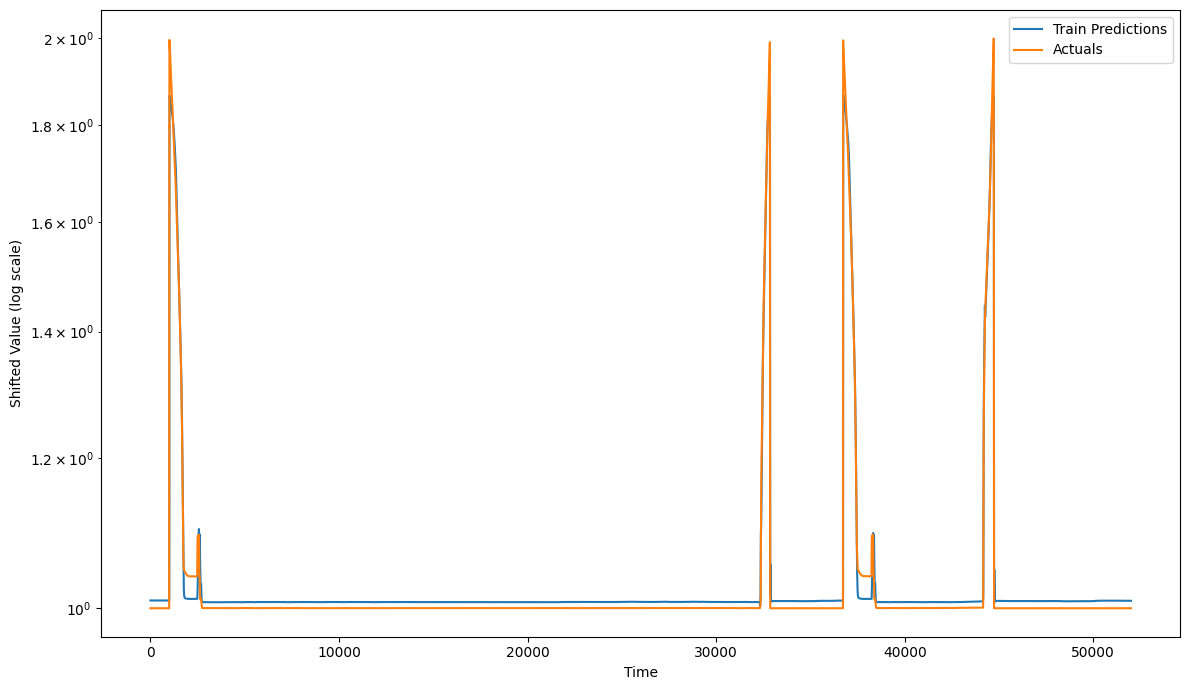

In [ ]:
# see the train data prediction result, showing on lineplot
def train_result(X_train, y_train, model,ax):
    train_predictions = model.predict(X_train)[:,:,0].flatten()
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train[:,:,0].flatten()})
    log_vis(train_results.index,None,train_results["Train Predictions"], label='Train Predictions',ax=ax)
    log_vis(train_results.index,None,train_results["Actuals"], label='Actuals',ax=ax)

fig, ax = plt.subplots(figsize = (12,7))
train_result(X_train, y_train, model,ax)
plt.show()

In [ ]:
whole_data[70435:71875].values

array([[  37.3714    ,  633.22622951,    5.006     ],
       [  34.97721333,  633.4       ,    5.006     ],
       [  34.661     ,  633.6483871 ,    5.00532258],
       ...,
       [  14.142471  , 1262.        ,   49.66      ],
       [  14.22274   , 1260.41935484,   49.88129032],
       [  23.803465  , 1248.        ,   51.62      ]])

In [ ]:
true_data = pd.DataFrame(scaled_data[70435:71875].copy(), columns =["MXC","CompressorOutlet","MixtureTank"])

In [ ]:
predicted_values= []
predicted_values.append(model.predict(whole_data[70435:71875][-window_size:].values.reshape(1, window_size, 3))[0][0])

1/1 [==============================] - 0s 80ms/step


array([0.05830034, 1.0621517 , 0.9591571 ], dtype=float32)

In [ ]:
true_data.loc[true_data.index[-1] + 1] = model.predict(whole_data[70435:71875][-window_size:].values.reshape(1, window_size, 3))[0][0]

1/1 [==============================] - 0s 81ms/step


In [ ]:
true_data

,MXC,CompressorOutlet,MixtureTank
0,0.000124,0.354884,0.000218
1,0.000124,0.354704,0.000218
2,0.000124,0.354959,0.000218
3,0.000124,0.355260,0.000218
4,0.000124,0.355457,0.000221
...,...,...,...
1436,0.000133,0.708837,0.058210
1437,0.000139,0.704003,0.061149
1438,0.000140,0.703123,0.061451
1439,0.000234,0.696213,0.063823


In [ ]:
##### Single step forecasting analysis
def predict_future(data, model, ax, window_size):
    future_steps = 200
    columns = ["MXC", "CompressorOutlet", "MixtureTank"]

    # take the last window_size data as input
    true_data = data
    input = true_data[-window_size:].values.reshape(1, window_size, 3)

    # Predict future values using the trained model
    predicted_values = []
    for _ in range(future_steps):
        # predict the next value
        prediction = model.predict(input)[0][0]
        predicted_values.append(prediction)
        # update the input for the next prediction
        true_data.loc[true_data.index[-1] + 1] = prediction
        print(true_data)
        input = true_data[-window_size:].values.reshape(1, window_size, 3)

    # store the true columns for reversing the standardization to the original scale
    true_columns = data.columns
    # Create timestamp index for the predicted values
    index = range(len(data), len(data) + future_steps)

    # Convert predicted values to a numpy array and reshape appropriately
    predicted_values = np.array(predicted_values).reshape(future_steps, 3)
    # Create a dataframe for the predicted values
    predicted_results = pd.DataFrame(data=predicted_values, index=index, columns=columns)

    # Plot the predicted values along with the actual values in the same plot for each dimension
    for col in columns:
        ax.plot(data.index, data[col], label=f'Actual {col}')
        ax.plot(predicted_results.index, predicted_results[col], label=f'Predicted {col}', linestyle='dashed')

fig, ax = plt.subplots(figsize=(14, 7))
scaled_input = pd.DataFrame(scaled_data[70450:71890].copy(), columns =["MXC","CompressorOutlet","MixtureTank"])
offline_futurre = predict_future(scaled_input, model, ax, window_size)
plt.show()

In [ ]:
model.predict(X_test[3435:3436, :, :])[0, -1, :]

1/1 [==============================] - 0s 80ms/step


array([0.014504  , 0.41192037, 0.03871733], dtype=float32)

In [ ]:
X_test[3435,:,:].shape

(1440, 3)

In [ ]:
copied = X_test[3435,:,:].copy()
copied[-1, :] = copied[-1, :] + model.predict(X_test[3435:3436, :, :])[0, -1, :]

1/1 [==============================] - 0s 80ms/step


In [ ]:
copied[-1, :]

array([0.01473795, 1.10813372, 0.10254073])

In [ ]:
copied.shape

(1440, 3)

## ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


   1/1382 [..............................] - ETA: 30s

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1382/1382 [==============================] - 7s 5ms/step
max MAE loss = 0.12015822731014585
Reconstruction error threshold:  60.12015822731015
3/3 [==============================] - 0s 6ms/step


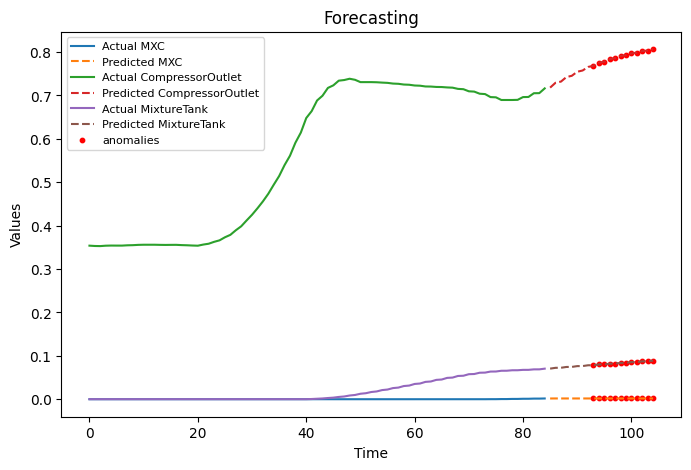

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def arima_predict(data, ax, window_size):
    future_steps = 20
    columns = ["MXC", "CompressorOutlet", "MixtureTank"]

    # Ensure the data is a DataFrame
    data = pd.DataFrame(data, columns=columns)

    # Container for the predictions
    predicted_values = {col: [] for col in columns}

    # Loop over each column to fit an ARIMA model and make predictions
    for col in columns:
        model = ARIMA(data[col][:-20], order=(2, 1, 2))
        model_fit = model.fit()

        # Forecast the next future_steps values
        forecast = model_fit.forecast(steps=future_steps)
        predicted_values[col] = forecast

    # Create integer index for the predicted values
    index = range(len(data)-20, len(data) + future_steps)

    # Create a DataFrame for the predicted values
    predicted_results = pd.DataFrame(predicted_values, index=index)

    # Plot the predicted values along with the actual values in the same plot for each dimension
    for col in columns:
        ax.plot(data.index, data[col], label=f'Actual {col}')
        ax.plot(predicted_results.index, predicted_results[col], label=f'Predicted {col}', linestyle='dashed')

    #ax.set_yscale('log')
    ax.axvline(x=len(data)-20, color='red', linestyle='-', label='forecasting start point')
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title('ARIMA Forecasting')

    # history_n_future = pd.concat([data, predicted_results])
    # ad_data = preprocess_single_dataframe(forecast_scaler.inverse_transform(history_n_future))

    # x_train_pred = ad_model.predict(x_train_combined)
    # train_mae_loss = np.mean(np.mean(np.abs(x_train_pred - x_train_combined), axis=-1),axis=-1)
    # print(f"max MAE loss = {np.max(train_mae_loss)}")
    # threshold = np.percentile(train_mae_loss, 100)+60
    # print("Reconstruction error threshold: ", threshold)
    # result = ad_model.predict(ad_data)
    # result_loss = np.mean(np.mean(np.abs(result - ad_data), axis=-1),axis=-1)

    # anomalies = result_loss > threshold

    # # Find indices of anomalous data points
    # anomalous_data_indices = []
    # for data_idx in range(future_steps - 1, len(history_n_future)):
    #     if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
    #         anomalous_data_indices.append(data_idx)


    # df_subset = history_n_future.iloc[anomalous_data_indices]
    # anomaly_detected = False
    # for col in columns:
    #     ax.scatter(df_subset.index, df_subset[col], color='red', s=10)
    #     if not anomaly_detected:
    #         ax.scatter([], [], color='red', label="anomalies", s=10)  # Add an empty scatter for legend
    #         anomaly_detected = True

    # if anomaly_detected:
    #     ax.legend(prop={'size': 8})

    return predicted_results

# Example usage
fig, ax = plt.subplots(figsize=(6, 4))

# Assuming data is already defined and is a DataFrame with the necessary columns
predicted_results = arima_predict(scaled_data[102288:102368].copy(), ax, window_size)

plt.show()

In [ ]:
ad_data = ad_scaler.transform(forecast_scaler.inverse_transform(predicted_results))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
x_train_pred = model.predict(x_train_combined)
train_mae_loss = np.mean(np.mean(np.abs(x_train_pred - x_train_combined), axis=-1),axis=-1)
print(f"max MAE loss = {np.max(train_mae_loss)}")
threshold = np.percentile(train_mae_loss, 95)
print("Reconstruction error threshold: ", threshold)

1382/1382 [==============================] - 7s 5ms/step
max MAE loss = 0.12015822731014585
Reconstruction error threshold:  0.07459291713187875


In [ ]:
ad_data = np.expand_dims(ad_data, axis=0)
ad_data.shape

(1, 20, 3)

In [ ]:
result = model.predict(ad_data)
result_loss = np.mean(np.mean(np.abs(result - ad_data), axis=-1),axis=-1)
result_loss

1/1 [==============================] - 0s 23ms/step


array([1467.21463134])

## Pre-trained TinyTimeMixer (TTM)

In [ ]:
# Referenced from https://colab.research.google.com/github/IBM/tsfm/blob/tutorial/notebooks/tutorial/ttm_tutorial.ipynb#scrollTo=9fe05685

# # Clone the ibm/tsfm
# ! git clone https://github.com/IBM/tsfm.git

# Change directory. Move inside the tsfm repo.
%cd tsfm

# Install the tsfm library
! pip install ".[notebooks]"

/content/drive/MyDrive/SHQCS/Python_side/tsfm
Processing /content/drive/MyDrive/SHQCS/Python_side/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.9 MB/s eta 0:00:00
  Using cached nvidia_c

In [ ]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# First Party
from tsfm_public.models.tinytimemixer.utils import (
    count_parameters,
    plot_preds,
)

# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

In [ ]:
# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "1024_96_v1"

# Forecasting parameters
context_length = 1024
forecast_length = 96
fewshot_fraction = 1

In [ ]:
%cd ..

/content/drive/MyDrive/SHQCS/Python_side


In [ ]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

dataset_path = "whole_data.csv"
timestamp_column = "date"
id_columns = []
target_columns = ["MXC","CompressorOutlet","MixtureTank"]
split_config = {
                "train": [0, 52000],
                "valid": [52000, 67000],
                "test": [67000, 74261]
            }
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 50881, val = 14905, test = 7166


In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION,prediction_filter_length=20)
zeroshot_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [ ]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [ ]:
zeroshot_trainer.evaluate(test_dataset)

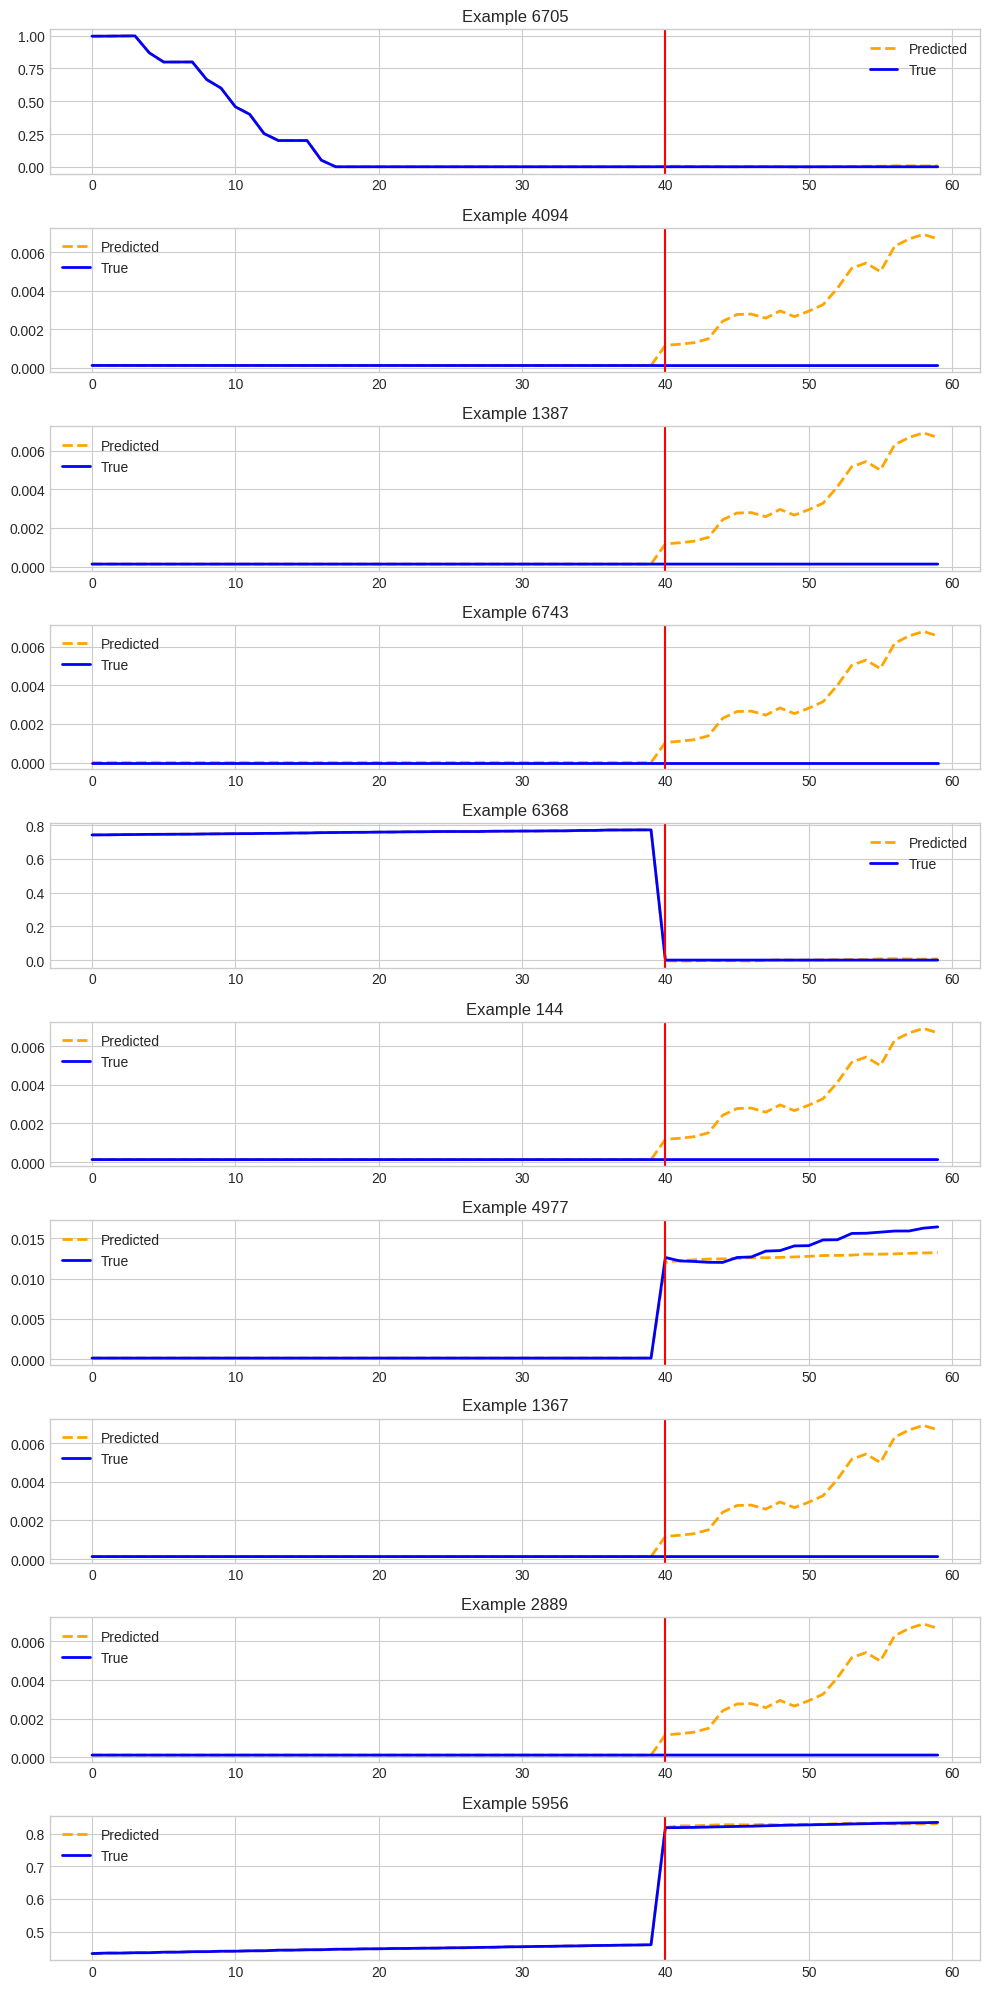

In [ ]:
# plot
plot_preds(trainer=zeroshot_trainer, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "ettm2"), plot_prefix="test_zeroshot", channel=0)

In [ ]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.8,prediction_filter_length=20)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=64, out_features=128, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=128, out_features=64, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
            

In [ ]:
print(
        "Number of params before freezing backbone",
        count_parameters(finetune_forecast_model),
    )

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 946336
Number of params after freezing the backbone 389984


In [ ]:
# Important parameters
learning_rate = 0.001
num_epochs = 200 # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 128

In [ ]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=30,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()0.026

Using learning rate = 0.001


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
1,0.730000,0.017389
2,0.438000,0.018233
3,0.277300,0.017741
4,0.177300,0.016363
5,0.116500,0.015230
6,0.063700,0.015175
7,0.046300,0.014643
8,0.038600,0.014157
9,0.032900,0.014063
10,0.032100,0.013829


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

[TrackingCallback] Mean Epoch Time = 11.993067462887383 seconds, Total Train Time = 1659.9187059402466


TrainOutput(global_step=44974, training_loss=0.03595598750059944, metrics={'train_runtime': 1659.9116, 'train_samples_per_second': 6130.567, 'train_steps_per_second': 47.954, 'total_flos': 1.0028867766327706e+17, 'train_loss': 0.03595598750059944, 'epoch': 113.0})

In [ ]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'eval_loss': 0.020919205620884895,
 'eval_runtime': 1.6619,
 'eval_samples_per_second': 4311.89,
 'eval_steps_per_second': 33.696,
 'epoch': 113.0}

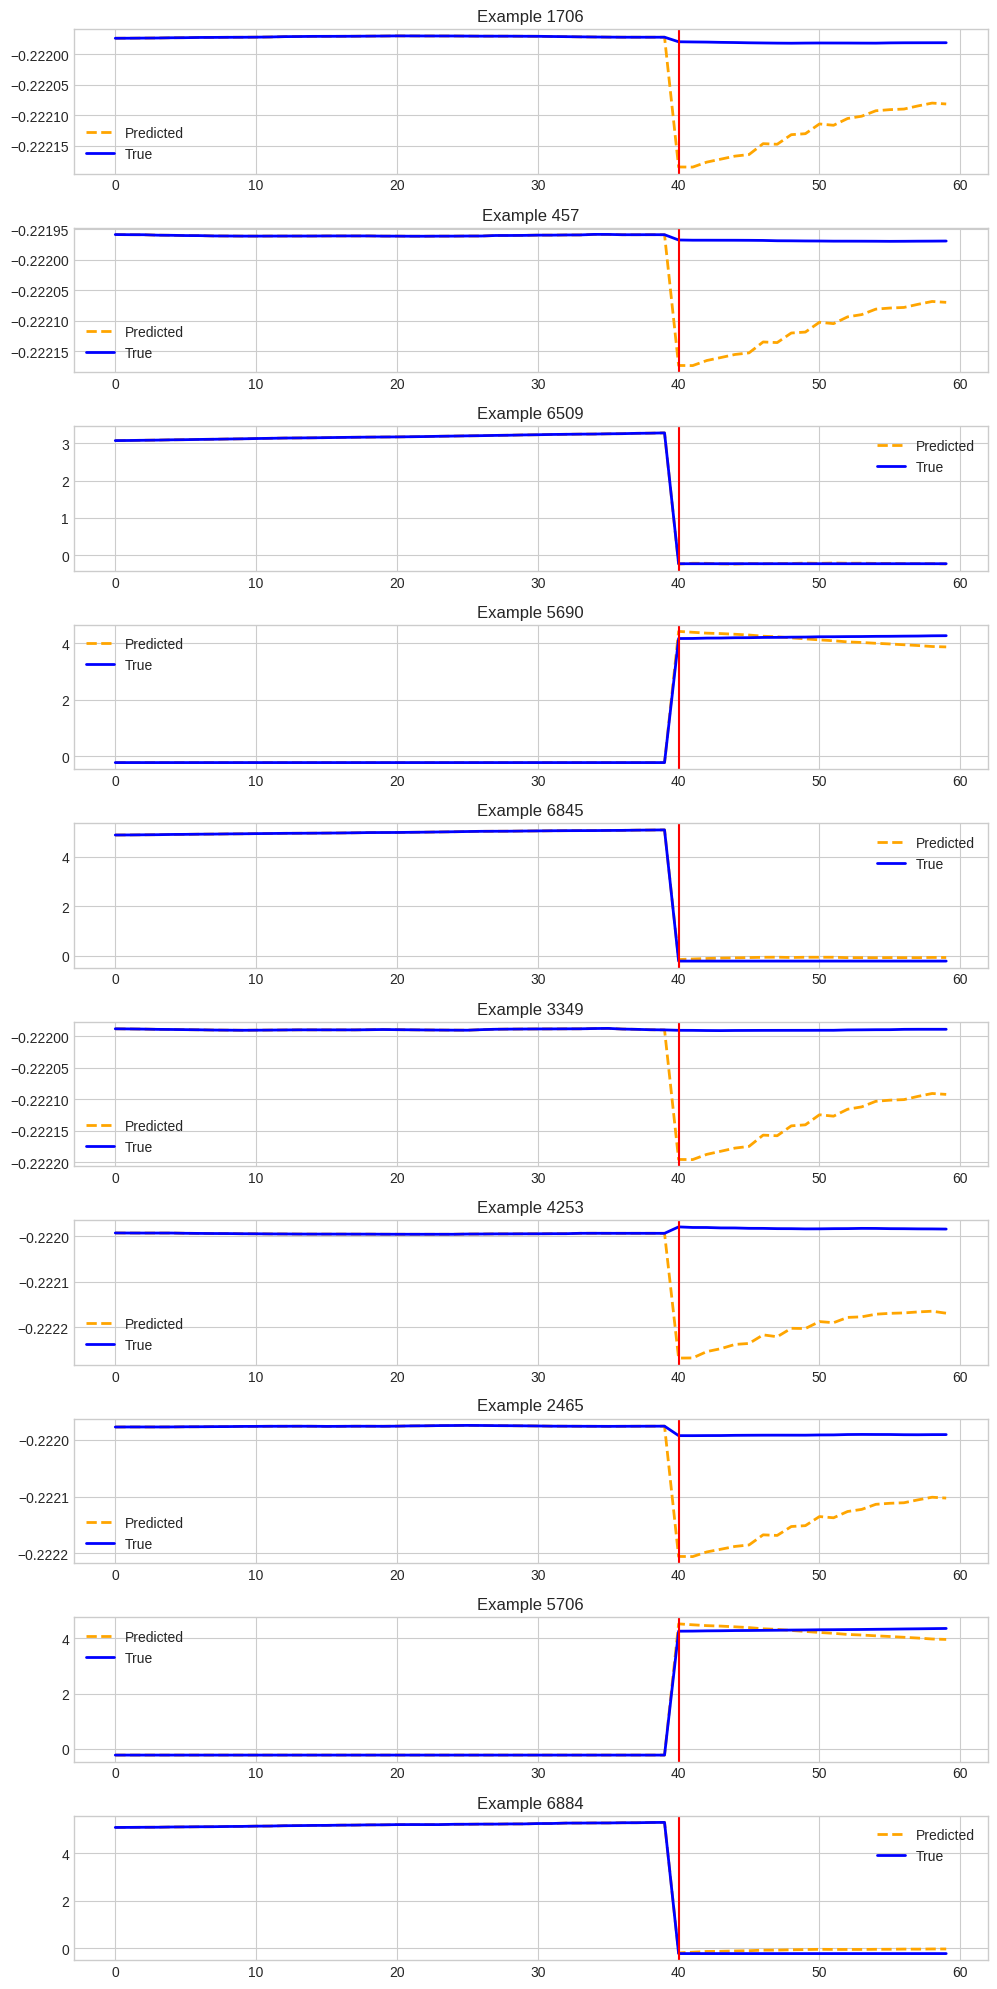

In [ ]:
# plot
plot_preds(trainer=finetune_forecast_trainer, dset=test_dataset, plot_dir=os.path.join(OUT_DIR, "ettm2"), plot_prefix="finetune", channel=0)

## XGBoost

In [ ]:
!pip install xgboost[gpu]

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import pickle

param_grid = {
    'n_estimators': [100, 500, 1000, 1500, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

In [ ]:
xgb_forecast = XGBRegressor(device='cuda', early_stopping_rounds=20)

random_search = RandomizedSearchCV(
    estimator=xgb_forecast,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=3,
    random_state=42
)

In [ ]:
random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

In [ ]:
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

In [ ]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

In [ ]:
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions = predictions.reshape(y_test.shape)

In [ ]:
plt.plot(y_test[32980,:,0])
plt.plot(predictions[33000,:,0])

## Auto-ARIMA

In [ ]:
!pip install pmdarima

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
import pmdarima as pm
import statsmodels.api as sm

In [ ]:
def find_best_arima_order(series, max_p=3, max_d=1, max_q=3):
    best_model = pm.auto_arima(series, start_p=0, start_q=0,
                               max_p=max_p, max_d=max_d, max_q=max_q,
                               seasonal=False, trace=False,
                               error_action='ignore', suppress_warnings=True,
                               stepwise=True,n_jobs=-1)
    return best_model.order, best_model

In [ ]:
forecast_scaler = MinMaxScaler()
ARIMA_train = forecast_scaler.fit_transform(whole_data)
ARIMA_train = pd.DataFrame(ARIMA_train, index=whole_data.index, columns=whole_data.columns)
ARIMA_train.replace(0, 1e-9, inplace=True)

In [ ]:
window_size = 50
horizon = 10
forecast_list = []
mse_list = []

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

for i in range(0,50000):
    sample_df = ARIMA_train.iloc[i:i+window_size]
    actual_df = ARIMA_train.iloc[i+window_size:i+window_size+horizon]

    forecast_values = pd.DataFrame(columns=whole_data.columns)

    for channel in sample_df.columns:
        if sample_df[channel].nunique() > 1:
            best_order, best_model = find_best_arima_order(sample_df[channel])
            forecast = best_model.predict(steps=horizon)
        else:
            best_order = (1, 0, 1)
            best_model = ARIMA(sample_df[channel], order=best_order).fit()
            forecast = best_model.forecast(steps=horizon)

        forecast_values[channel] = forecast

    mse = mean_squared_error(actual_df, forecast_values)
    mse_list.append(mse)

In [ ]:
np.mean(mse_list)

In [ ]:
sample_df = ARIMA_train.iloc[118800:119300]

forecast_values = pd.DataFrame(columns=whole_data.columns)
for channel in sample_df.columns:
        if sample_df[channel].nunique() > 1:
            best_order, best_model = find_best_arima_order(sample_df[channel])
            forecast = best_model.predict(steps=20)
            print(best_order)
        else:
            best_order = (1, 0, 1)
            best_model = ARIMA(sample_df[channel], order=best_order).fit()
            forecast = best_model.forecast(steps=20)

        forecast_values[channel] = forecast


forecast = best_model.predict(steps=horizon)

In [ ]:
ARIMA_train.iloc[118800:119300].plot()

In [ ]:
forecast_values['MXC'].plot()

## Bench Mark

In [ ]:
# Instantiate the hypermodel
num_samples = X_train.shape[0]
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

input_size = window_size * num_features
theta_size = (window_size+horizon)*num_features


nbeats_forecast = NBEATS_Forecasting_HyperModel(num_samples=num_samples,
                                           window_size=window_size,
                                           features=num_features,
                                           theta_size=theta_size,
                                           horizon=horizon)

In [ ]:
nbeats_model = load_best_tuner(nbeats_forecast, 'nbeats_forecast')

In [ ]:
nbeats_pred = nbeats_model.predict(X_test)

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy().mean(),
          "mse": mse.numpy().mean(),
          "rmse": rmse.numpy().mean(),
          "mape": mape.numpy().mean(),
          "mase": mase.numpy().mean()}

In [ ]:
nbeats_results = evaluate_preds(y_test, nbeats_pred)
nbeats_results

In [ ]:
def forecast_visualization(X_true, y_true, y_pred, title, horizon=20):
    # Cast inputs to TensorFlow tensors
    X_true = tf.cast(X_true, dtype=tf.float32)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    columns = ["MXC", "CompressorOutlet", "MixtureTank"]

    # Convert X_true and y_true to numpy arrays and concatenate them
    X_true_np = X_true.numpy()
    y_true_np = y_true.numpy()

    # Create a DataFrame for the combined actual values
    combined_true = pd.DataFrame(
        np.concatenate([X_true_np, y_true_np], axis=0),
        columns=columns
    )

    # Create a DataFrame for the predicted values
    index_pred = range(len(combined_true) - len(y_true), len(combined_true) - len(y_true) + horizon)
    predicted_results = pd.DataFrame(y_pred.numpy(), index=index_pred, columns=columns)

    for col in columns:
        ax.plot(combined_true.index, combined_true[col], label=f'Actual {col}')
        ax.plot(predicted_results.index, predicted_results[col], label=f'Predicted {col}', linestyle='dashed')

    ax.axvline(x=len(X_true), color='red', linestyle='-', label='forecasting start point')
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title(title + ' Forecasting')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sample_num = 21922
forecast_visualization(X_test[sample_num,:,:], y_test[sample_num,:,:], nbeats_pred[sample_num,:,:], 'N-Beats')
plt.show()

In [ ]:
num_samples = X_train.shape[0]
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

lstm_forecast = LSTM_Forecasting_HyperModel(num_samples, timesteps, num_features, horizon)
lstm_model = load_best_tuner(lstm_forecast, 'lstm_forecast')

In [ ]:
lstm_pred = lstm_model.predict(X_test)

In [ ]:
lstm_results = evaluate_preds(y_test, lstm_pred)
lstm_results

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sample_num = 21922
forecast_visualization(X_test[sample_num,:,:], y_test[sample_num,:,:], lstm_pred[sample_num,:,:], 'LSTM')
plt.show()

In [ ]:
import pickle
with open('xgb_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
xgb_pred = loaded_model.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sample_num = 21922
forecast_visualization(X_test[sample_num,:,:], y_test[sample_num,:,:], xgb_pred[sample_num,:,:], 'XGBoost')
plt.show()

In [ ]:
arima_results = {'mse': 9.597994e-05,
 'mae': 0.00064527115,
 'rmse': 0.0011091862,
 'mape': 1131.4152}

In [ ]:
model_results = pd.DataFrame({"lstm_model": lstm_results,
                              "nbeats model": nbeats_results,
                              "xgb_model": xgb_results,
                              "arima_model": arima_results}).T
model_results

In [ ]:
# Select only 'mse' and 'mae' for plotting
metrics_to_plot = ["mse", "mae"]
model_results_filtered = model_results[metrics_to_plot]

# Sort the DataFrame by 'mae'
model_results_sorted = model_results_filtered.sort_values(by="mse")

# Plotting MSE and MAE for each model
model_results_sorted.plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Model Metrics")
plt.xlabel("Models")
plt.ylabel("Metrics")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.show()

# TODO:


# Reference  
https://arxiv.org/pdf/2212.03637   
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10007300/pdf/sensors-23-02844.pdf  
https://forecastegy.com/posts/multiple-time-series-forecasting-nbeats-python/#what-is-n-beats